<a href="https://colab.research.google.com/github/khairul746/IDCamp-ML-Engineer-2024-Projects/blob/main/Klasifikasi-Gambar/Klasifikasi_Gambar.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Images Classification
Khairullah Ilyas \
Dicoding IDCamp 2024 : Intermediate Level Submission

## 1. Import Library

In [1]:
import kagglehub
import numpy as np
import pandas as pd
import tensorflow as tf
import cv2
from PIL import Image
import matplotlib.pyplot as plt

import zipfile
import os
import shutil
import os

from sklearn.model_selection import train_test_split

In [2]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import Callback

## 2. Load Dataset

In [3]:
kagglehub.login()

Kaggle credentials set.
Kaggle credentials successfully validated.


In [4]:
# Download dataset
!kaggle datasets download --force yessicatuteja/skycity-the-city-landscape-dataset

Dataset URL: https://www.kaggle.com/datasets/yessicatuteja/skycity-the-city-landscape-dataset
License(s): CC0-1.0
 97% 113M/117M [00:01<00:00, 106MB/s]
100% 117M/117M [00:01<00:00, 89.4MB/s]


In [5]:
# Ekstrak dataset
zip_path = 'skycity-the-city-landscape-dataset.zip'
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall()

In [6]:
# Path to the train directory
data_dir = "/content/Cityscape Dataset"

### 2.1. Images Count

In [7]:
def count_images(data_dir):
    class_counts = {}
    total_images = 0
    for class_name in os.listdir(data_dir):
        class_path = os.path.join(data_dir, class_name)
        if os.path.isdir(class_path):
            image_count = len(os.listdir(class_path))
            class_counts[class_name] = image_count
            total_images += image_count
    return class_counts, total_images


class_counts, total_images = count_images(data_dir)

print("Jumlah gambar per kelas:")
for class_name, count in class_counts.items():
    print(f"- {class_name}: {count}")

print(f"\nTotal jumlah gambar: {total_images}")


Jumlah gambar per kelas:
- Commercial: 800
- Park: 800
- Parking: 800
- Industrial: 800
- Landmark: 800
- Stadium: 800
- Residential: 800
- Intersection: 800
- Bridge: 800
- Playground: 800

Total jumlah gambar: 8000


### 2.2. Image Resolutions Checking

In [8]:
# Dictionary to store image resolutions
image_resolutions = {}

# Counter to limit the number of images processed
image_count = 0
max_images = 10

# Iterate through each subfolder and image file
for subdir, _, files in os.walk(data_dir):
    for file in files:
        if file.endswith(('jpg', 'jpeg', 'png')):
            file_path = os.path.join(subdir, file)
            with Image.open(file_path) as img:
                image_resolutions[file_path] = img.size
                image_count += 1
                if image_count >= max_images:
                    break

# Print the resolutions
for path, resolution in image_resolutions.items():
    print(f'{path}: {resolution}')

/content/Cityscape Dataset/Commercial/703.jpg: (256, 256)
/content/Cityscape Dataset/Commercial/239.jpg: (256, 256)
/content/Cityscape Dataset/Commercial/317.jpg: (256, 256)
/content/Cityscape Dataset/Commercial/215.jpg: (256, 256)
/content/Cityscape Dataset/Commercial/304.jpg: (256, 256)
/content/Cityscape Dataset/Commercial/754.jpg: (256, 256)
/content/Cityscape Dataset/Commercial/075.jpg: (256, 256)
/content/Cityscape Dataset/Commercial/569.jpg: (256, 256)
/content/Cityscape Dataset/Commercial/764.jpg: (256, 256)
/content/Cityscape Dataset/Commercial/210.jpg: (256, 256)
/content/Cityscape Dataset/Park/703.jpg: (256, 256)
/content/Cityscape Dataset/Parking/703.jpg: (256, 256)
/content/Cityscape Dataset/Industrial/703.jpg: (256, 256)
/content/Cityscape Dataset/Landmark/703.jpg: (256, 256)
/content/Cityscape Dataset/Stadium/703.jpg: (256, 256)
/content/Cityscape Dataset/Residential/703.jpg: (256, 256)
/content/Cityscape Dataset/Intersection/703.jpg: (256, 256)
/content/Cityscape Datase

## 3. Augmentasi Gambar dan Pemisahan Data

### 3.1. Train test split

In [9]:
# Path to the dataset
train_dir = "data/train"
test_dir = "data/test"

# Making new directory for saving divided data
for folder in [train_dir, test_dir]:
    for class_name in os.listdir(data_dir):
        os.makedirs(os.path.join(folder, class_name), exist_ok=True)

In [10]:
# Taking images list for each class
for class_name in os.listdir(data_dir):
    class_path = os.path.join(data_dir, class_name)
    images = os.listdir(class_path)

    train_imgs, test_imgs = train_test_split(images, test_size=0.2, random_state=42)  # 80% Train, 20% Test
    # Copy images to the new directory
    for img in train_imgs:
        shutil.copy(os.path.join(class_path, img), os.path.join(train_dir, class_name, img))
    for img in test_imgs:
        shutil.copy(os.path.join(class_path, img), os.path.join(test_dir, class_name, img))


### 3.2. Augmentasi Gambar

In [11]:
# Create an ImageDataGenerator for training data with augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=45,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True
)

# Create a generator for the training data
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

# Create a generator for the validation data
validation_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='validation',
    shuffle=True
)

Found 5120 images belonging to 10 classes.
Found 1280 images belonging to 10 classes.


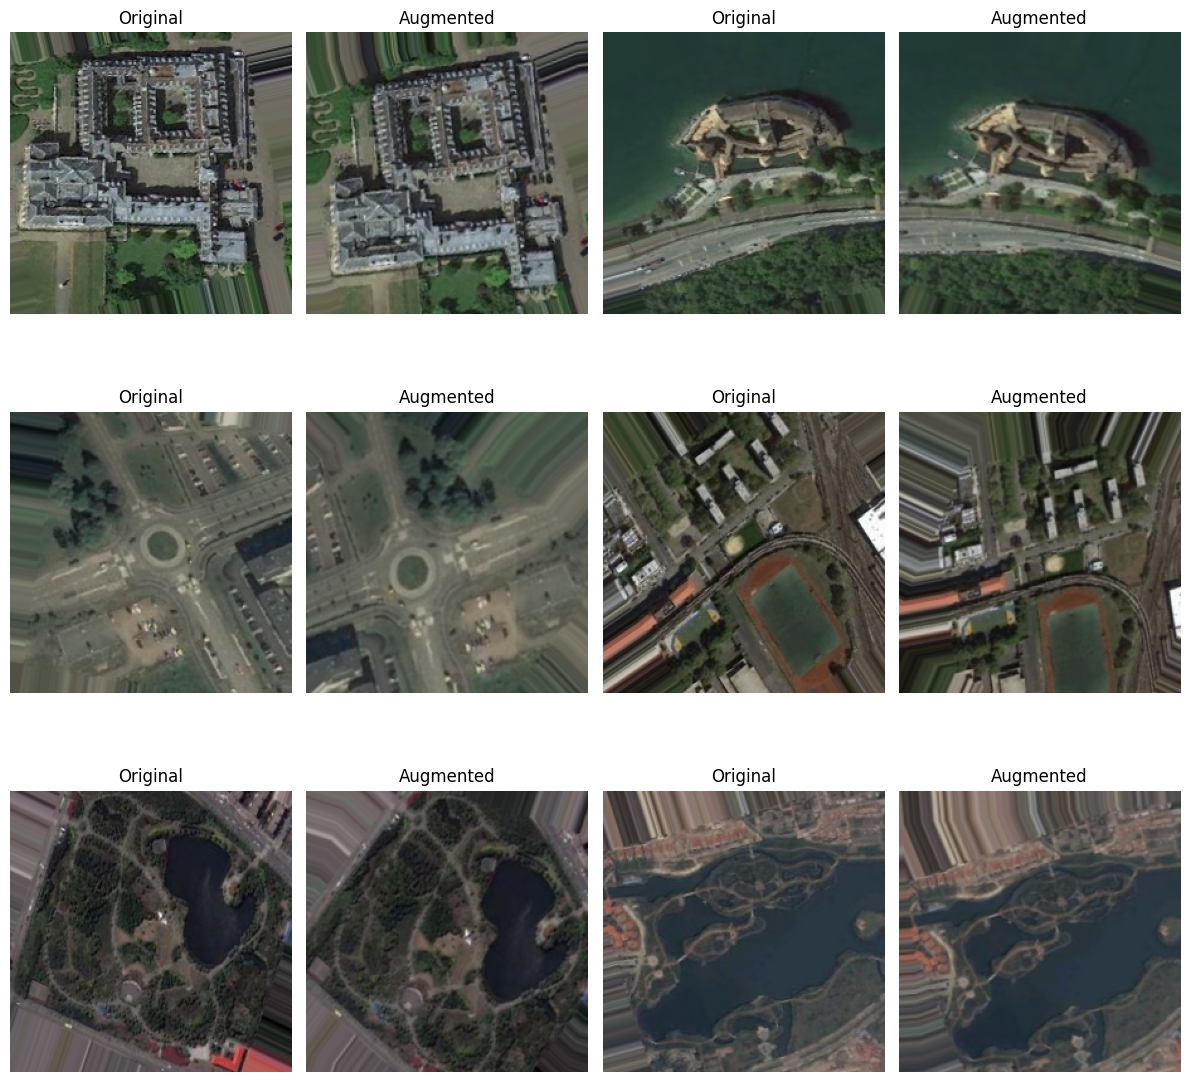

In [12]:
# Ambil batch gambar dari train_generator
images, labels = next(train_generator)

# Tampilkan beberapa gambar asli dan hasil augmentasi
plt.figure(figsize=(12, 12))
for i in range(6):
    plt.subplot(3, 4, 2*i+1)
    plt.imshow(images[i])
    plt.title('Original')
    plt.axis('off')

    # Augmentasi gambar
    augmented_image = train_datagen.random_transform(images[i])
    plt.subplot(3, 4, 2*i+2)
    plt.imshow(augmented_image)
    plt.title('Augmented')
    plt.axis('off')

plt.tight_layout()
plt.show()

## 4. Model Development

In [ ]:
tf.keras.backend.clear_session

<function keras.src.backend.common.global_state.clear_session(free_memory=True)>

In [13]:
class StopTrainingCallback(Callback):
    def __init__(self, patience=3):
        super(StopTrainingCallback, self).__init__()
        self.patience = patience
        self.best_val_loss = float('inf')
        self.wait = 0

    def on_epoch_end(self, epoch, logs={}):
        if logs.get("accuracy") >= 0.95:
            print("\n Akurasi 95% tercapai. Proses train dihentikan...\n")
            self.model.stop_training = True
            return

        current_val_loss = logs.get("val_loss")
        if current_val_loss < self.best_val_loss:
            self.best_val_loss = current_val_loss
            self.wait = 0
        else:
            self.wait += 1
            if self.wait >= self.patience:
                print(f"\n Tidak ada penurunan nilai loss validasi setelah {self.patience} epochs. Proses train dihentikan...\n")
                self.model.stop_training = True

In [14]:
class PlotPerIteration(tf.keras.callbacks.Callback):
    def __init__(self, interval=100):
        self.interval = interval
        self.losses = []
        self.val_losses = []
        self.accuracies = []
        self.val_accuracies = []
        self.iterations = 0
        self.epochs = 0

    def on_batch_end(self, batch, logs=None):
        self.iterations += 1
        if self.iterations % self.interval == 0:
            loss = logs.get('loss')
            accuracy = logs.get('accuracy')
            if loss is not None:
                self.losses.append(loss)
            if accuracy is not None:
                self.accuracies.append(accuracy)

    def on_epoch_end(self, epoch, logs=None):
        self.epochs += 1
        val_loss = logs.get('val_loss')
        val_accuracy = logs.get('val_accuracy')
        if val_loss is not None:
            self.val_losses.append(val_loss)
        if val_accuracy is not None:
            self.val_accuracies.append(val_accuracy)
        self.plot_metrics()

    def plot_metrics(self):
        plt.figure(figsize=(10, 5))

        plt.subplot(1, 2, 1)
        plt.plot(range(0, len(self.accuracies)*self.interval, self.interval), self.accuracies, label='Train')
        plt.plot(
            np.linspace(
                len(self.accuracies) * self.interval / len(self.val_accuracies),
                len(self.accuracies) * self.interval,
                int(len(self.val_accuracies))
                ),
            self.val_accuracies, label='Validation')
        plt.title('Model Accuracy (per iteration)')
        plt.ylabel('Accuracy')
        plt.xlabel('Iteration')
        locator = plt.AutoLocator()
        formatter = plt.FormatStrFormatter('%d')
        plt.gca().xaxis.set_major_locator(locator)
        plt.gca().xaxis.set_major_formatter(formatter)
        plt.grid()
        plt.legend(['Train', 'Validation'], loc='upper left')

        plt.subplot(1, 2, 2)
        plt.plot(range(0, len(self.losses)*self.interval, self.interval), self.losses, label='Train')
        plt.plot(
            np.linspace(
                len(self.losses) * self.interval / len(self.val_losses),
                len(self.losses) * self.interval,
                int(len(self.val_losses))
                ),
            self.val_losses, label='Validation')
        plt.title('Model Loss (per iteration)')
        plt.ylabel('Loss')
        plt.xlabel('Iteration')
        locator = plt.AutoLocator()
        formatter = plt.FormatStrFormatter('%d')
        plt.gca().xaxis.set_major_locator(locator)
        plt.gca().xaxis.set_major_formatter(formatter)
        plt.grid()
        plt.legend(['Train', 'Validation'], loc='upper left')

        plt.tight_layout()
        plt.show()

plot_callback = PlotPerIteration(interval=10)

In [15]:
model = Sequential()
model.add(Conv2D(64, (3, 3), activation='relu', input_shape=(224, 224, 3)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu', input_shape=(224, 224, 3)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu', input_shape=(224, 224, 3)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu', input_shape=(224, 224, 3)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(10, activation='softmax'))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 403ms/step - accuracy: 0.1424 - loss: 2.2478

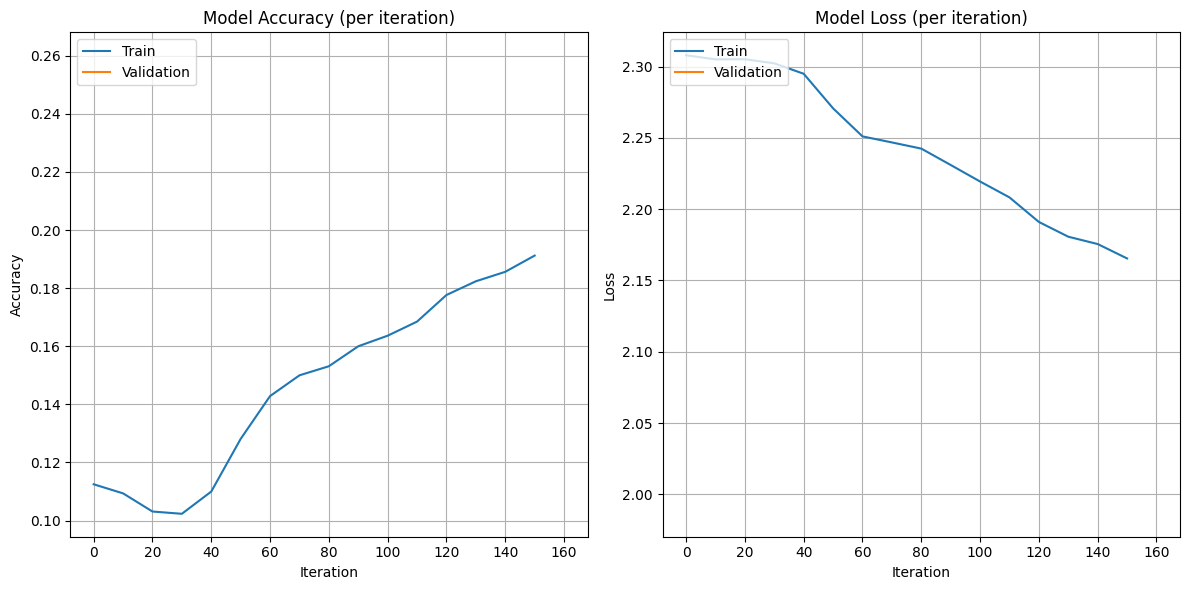

160/160 ━━━━━━━━━━━━━━━━━━━━ 106s 538ms/step - accuracy: 0.1428 - loss: 2.2473 - val_accuracy: 0.2602 - val_loss: 1.9864
Epoch 2/50
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 403ms/step - accuracy: 0.2882 - loss: 1.8881

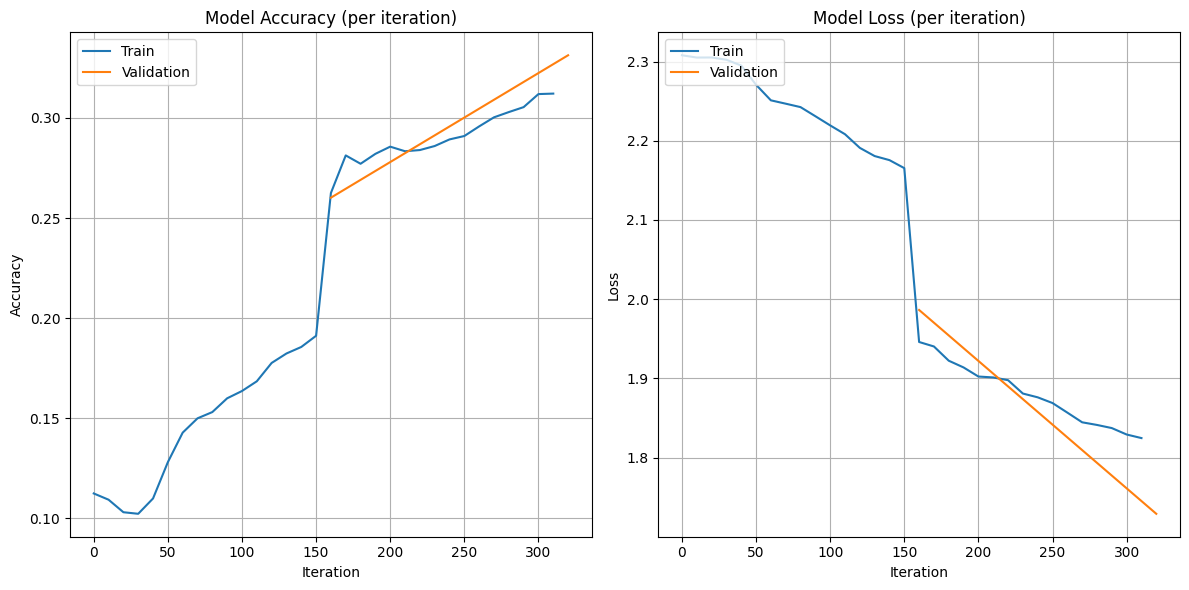

160/160 ━━━━━━━━━━━━━━━━━━━━ 119s 496ms/step - accuracy: 0.2883 - loss: 1.8877 - val_accuracy: 0.3313 - val_loss: 1.7290
Epoch 3/50
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 409ms/step - accuracy: 0.3738 - loss: 1.6779

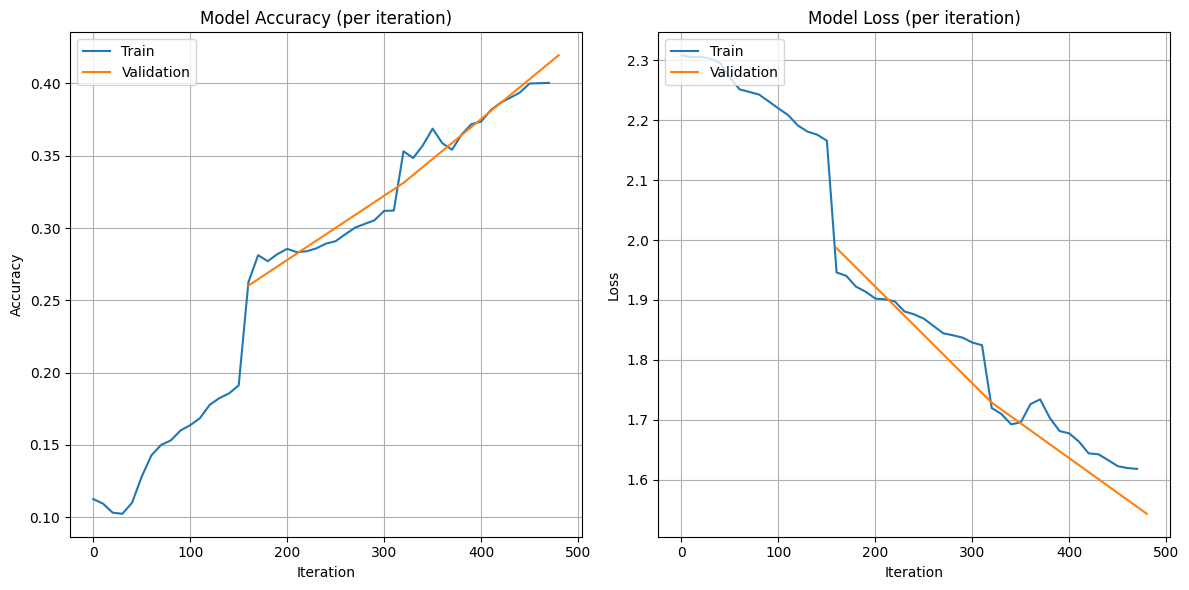

160/160 ━━━━━━━━━━━━━━━━━━━━ 80s 502ms/step - accuracy: 0.3740 - loss: 1.6775 - val_accuracy: 0.4195 - val_loss: 1.5436
Epoch 4/50
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 408ms/step - accuracy: 0.4492 - loss: 1.5103

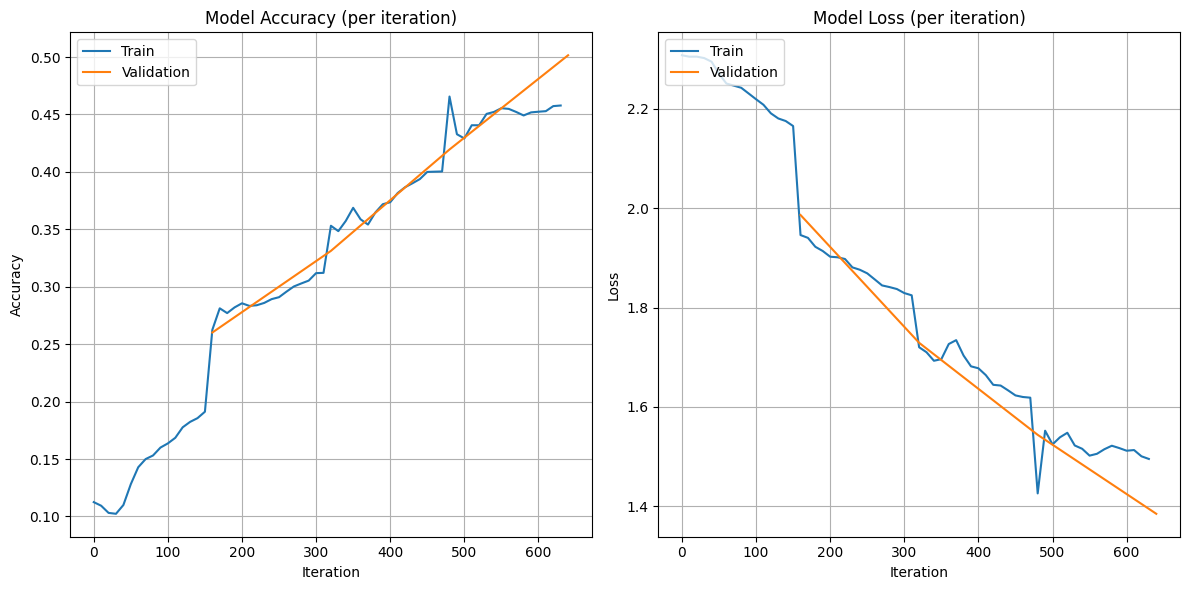

160/160 ━━━━━━━━━━━━━━━━━━━━ 83s 506ms/step - accuracy: 0.4493 - loss: 1.5102 - val_accuracy: 0.5016 - val_loss: 1.3847
Epoch 5/50
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 420ms/step - accuracy: 0.4882 - loss: 1.4156

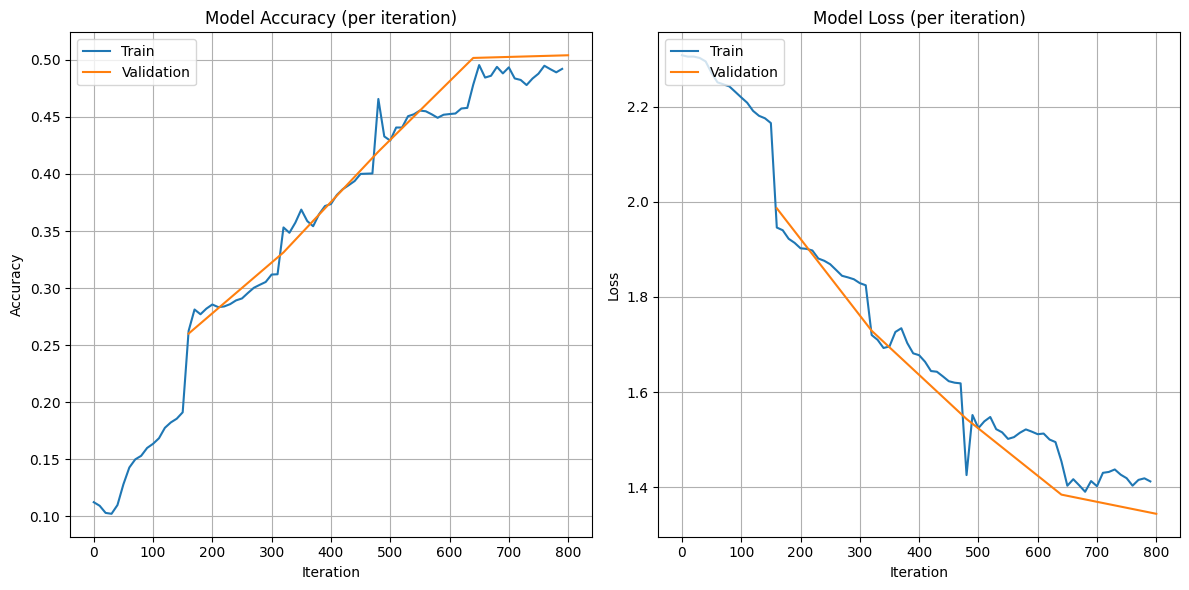

160/160 ━━━━━━━━━━━━━━━━━━━━ 82s 512ms/step - accuracy: 0.4882 - loss: 1.4155 - val_accuracy: 0.5039 - val_loss: 1.3444
Epoch 6/50
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 416ms/step - accuracy: 0.5408 - loss: 1.3036

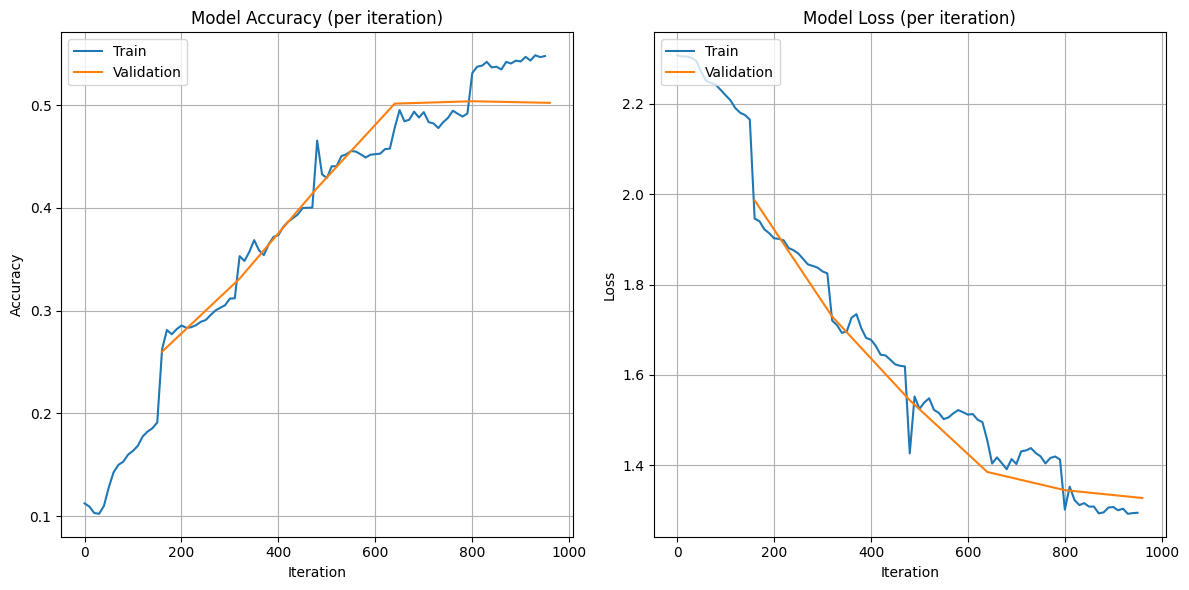

160/160 ━━━━━━━━━━━━━━━━━━━━ 81s 509ms/step - accuracy: 0.5408 - loss: 1.3036 - val_accuracy: 0.5023 - val_loss: 1.3270
Epoch 7/50
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 410ms/step - accuracy: 0.5674 - loss: 1.2363

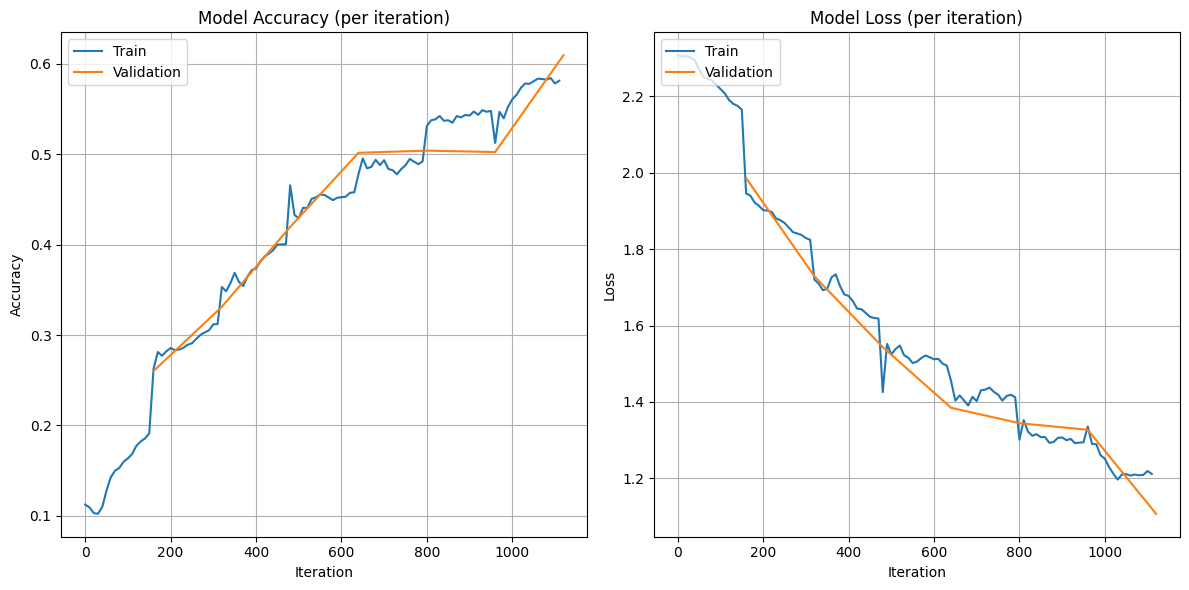

160/160 ━━━━━━━━━━━━━━━━━━━━ 82s 508ms/step - accuracy: 0.5674 - loss: 1.2362 - val_accuracy: 0.6094 - val_loss: 1.1071
Epoch 8/50
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 411ms/step - accuracy: 0.6168 - loss: 1.1357

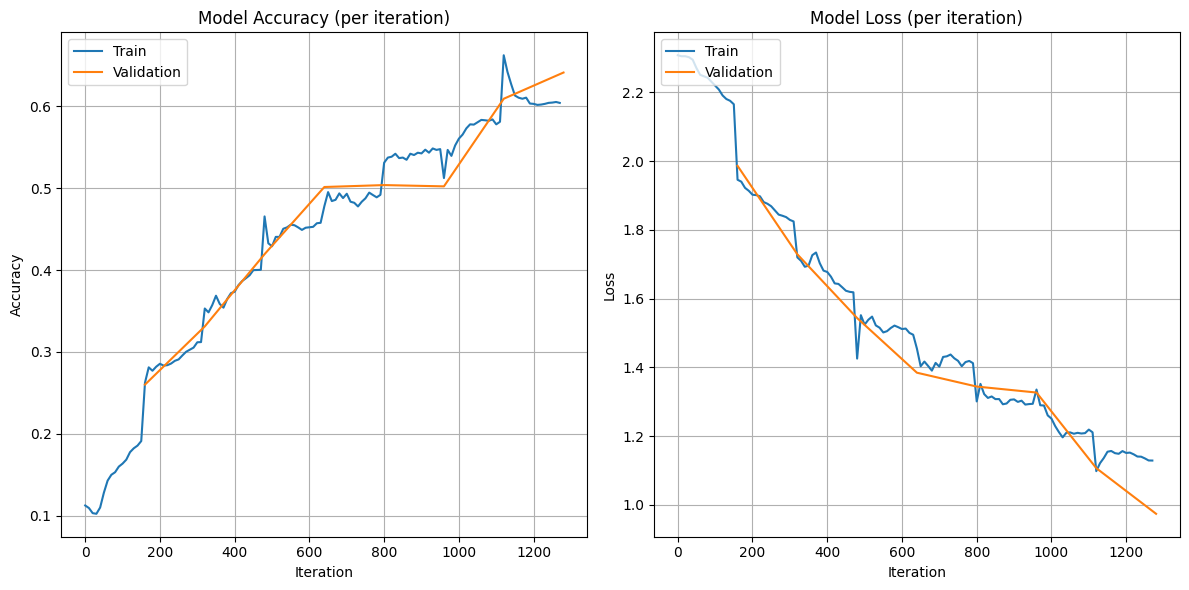

160/160 ━━━━━━━━━━━━━━━━━━━━ 81s 504ms/step - accuracy: 0.6167 - loss: 1.1357 - val_accuracy: 0.6414 - val_loss: 0.9743
Epoch 9/50
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 409ms/step - accuracy: 0.6263 - loss: 1.0825

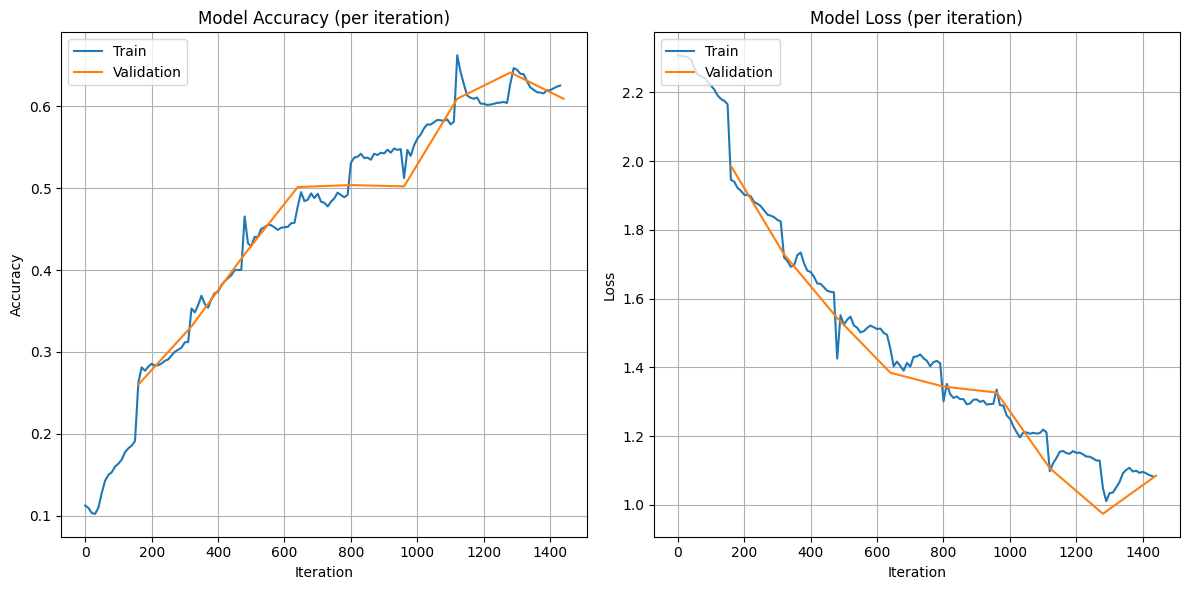

160/160 ━━━━━━━━━━━━━━━━━━━━ 82s 501ms/step - accuracy: 0.6263 - loss: 1.0825 - val_accuracy: 0.6094 - val_loss: 1.0854
Epoch 10/50
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 412ms/step - accuracy: 0.6427 - loss: 1.0327

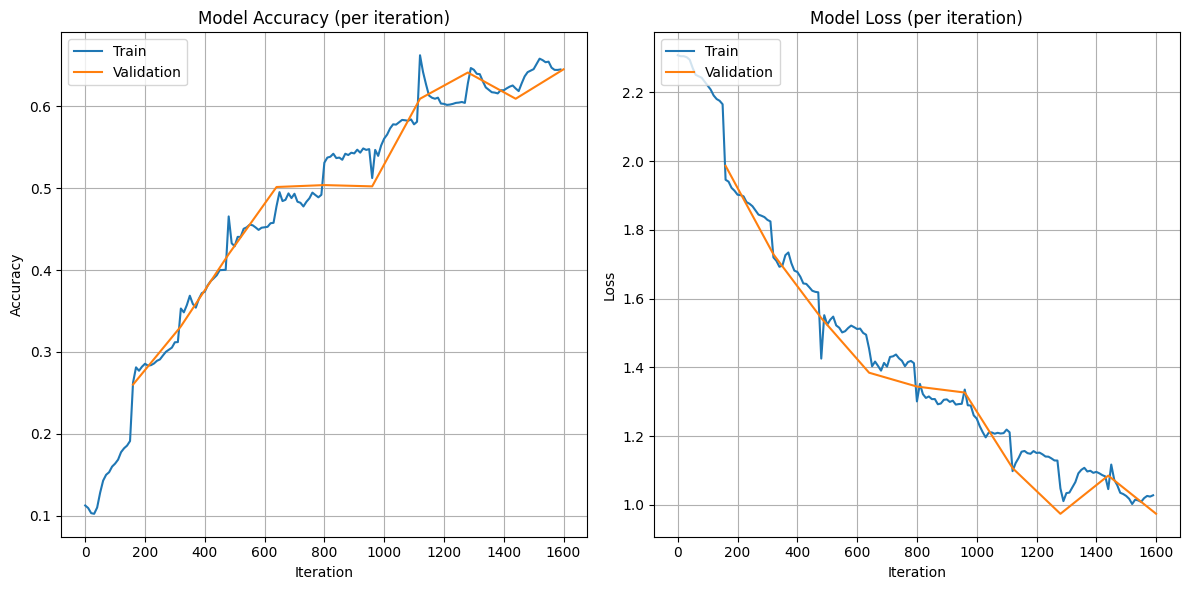

160/160 ━━━━━━━━━━━━━━━━━━━━ 82s 505ms/step - accuracy: 0.6427 - loss: 1.0326 - val_accuracy: 0.6453 - val_loss: 0.9744
Epoch 11/50
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 408ms/step - accuracy: 0.6641 - loss: 0.9620

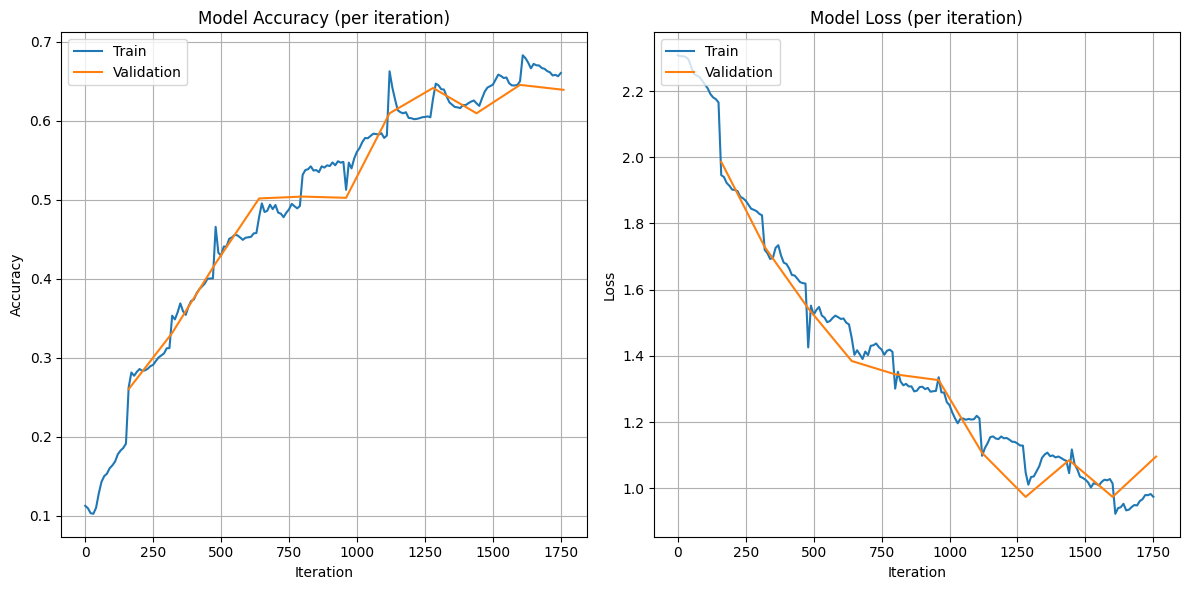

160/160 ━━━━━━━━━━━━━━━━━━━━ 80s 501ms/step - accuracy: 0.6641 - loss: 0.9620 - val_accuracy: 0.6391 - val_loss: 1.0961
Epoch 12/50
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 413ms/step - accuracy: 0.6802 - loss: 0.9567

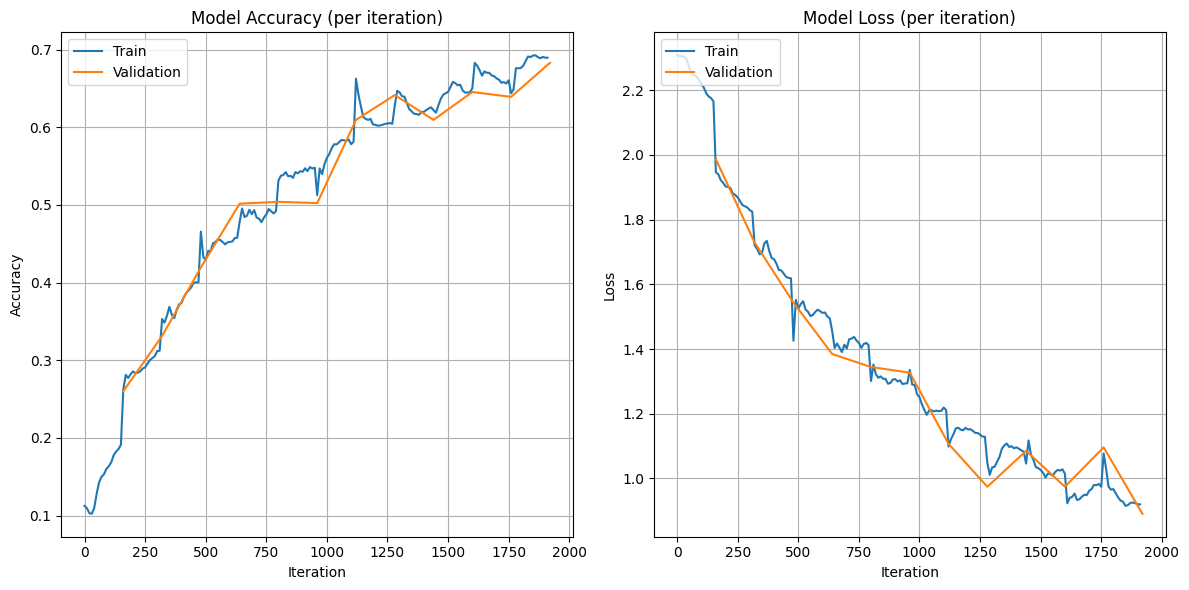

160/160 ━━━━━━━━━━━━━━━━━━━━ 82s 505ms/step - accuracy: 0.6802 - loss: 0.9565 - val_accuracy: 0.6828 - val_loss: 0.8908
Epoch 13/50
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 413ms/step - accuracy: 0.6863 - loss: 0.9034

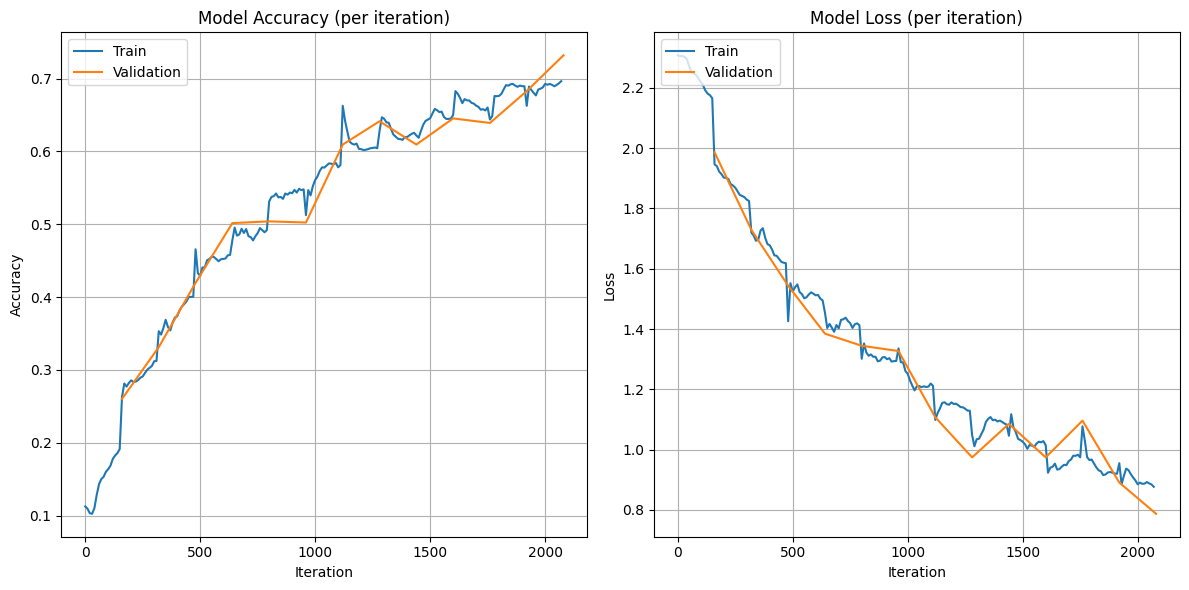

160/160 ━━━━━━━━━━━━━━━━━━━━ 81s 504ms/step - accuracy: 0.6863 - loss: 0.9032 - val_accuracy: 0.7320 - val_loss: 0.7872
Epoch 14/50
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 411ms/step - accuracy: 0.7028 - loss: 0.8541

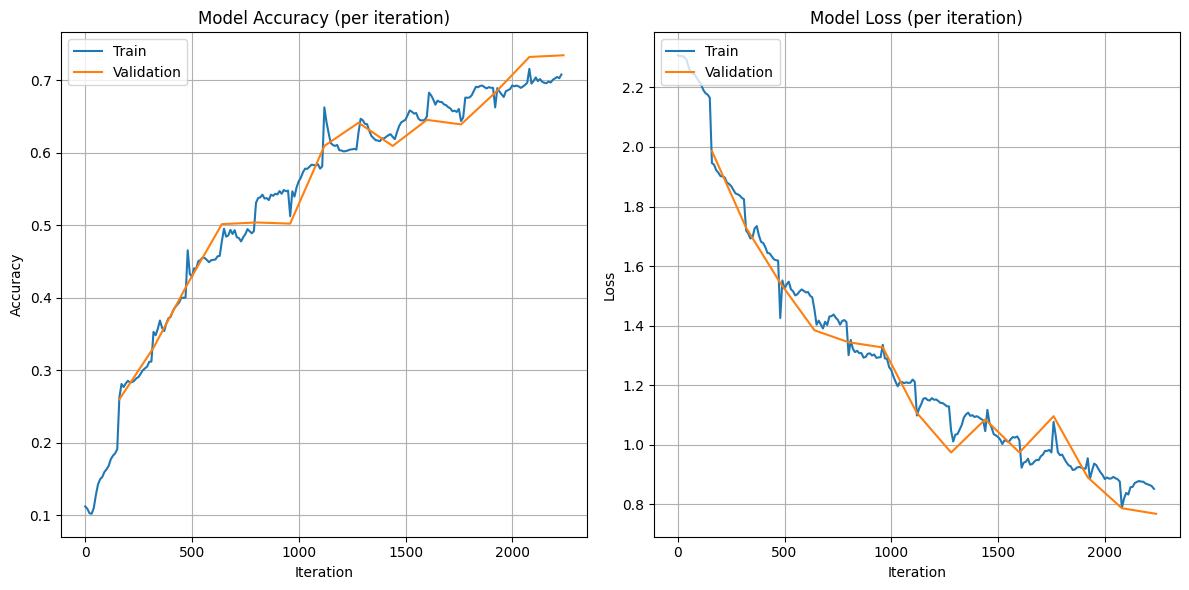

160/160 ━━━━━━━━━━━━━━━━━━━━ 83s 509ms/step - accuracy: 0.7028 - loss: 0.8541 - val_accuracy: 0.7344 - val_loss: 0.7685
Epoch 15/50
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 416ms/step - accuracy: 0.7161 - loss: 0.8162

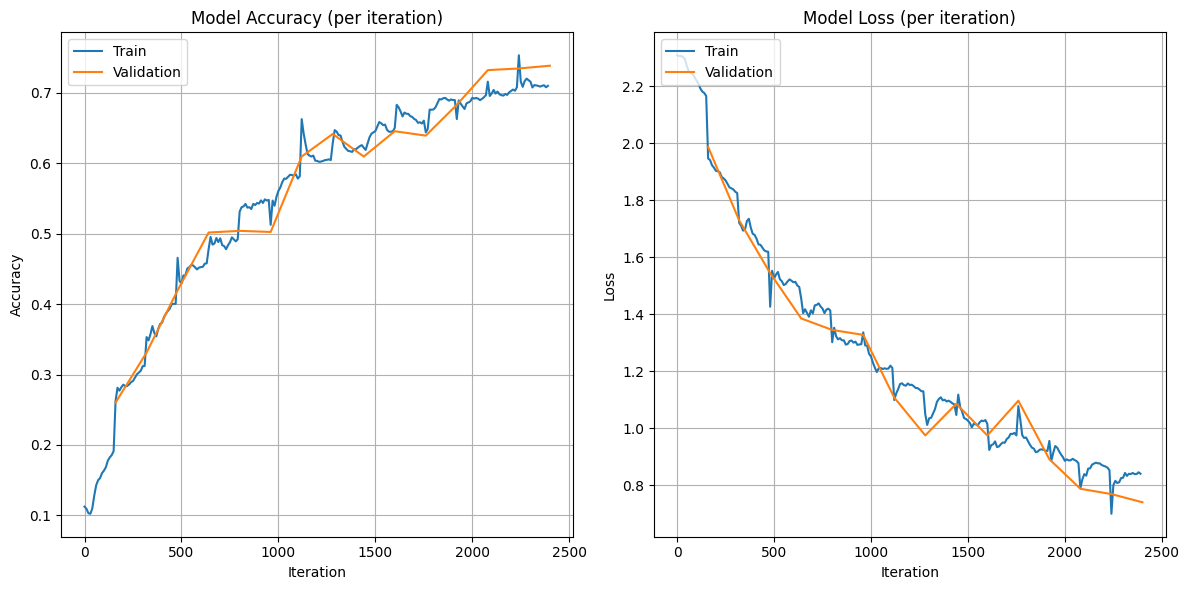

160/160 ━━━━━━━━━━━━━━━━━━━━ 82s 508ms/step - accuracy: 0.7161 - loss: 0.8164 - val_accuracy: 0.7383 - val_loss: 0.7398
Epoch 16/50
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 419ms/step - accuracy: 0.7181 - loss: 0.7960

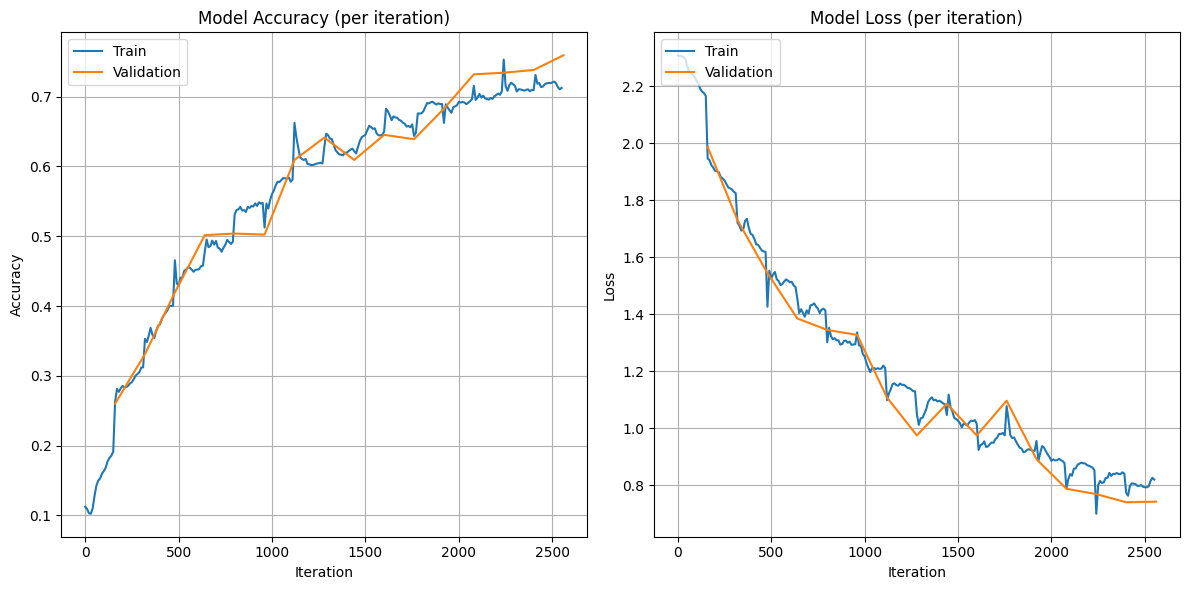

160/160 ━━━━━━━━━━━━━━━━━━━━ 82s 510ms/step - accuracy: 0.7181 - loss: 0.7961 - val_accuracy: 0.7594 - val_loss: 0.7420
Epoch 17/50
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 413ms/step - accuracy: 0.7345 - loss: 0.7471

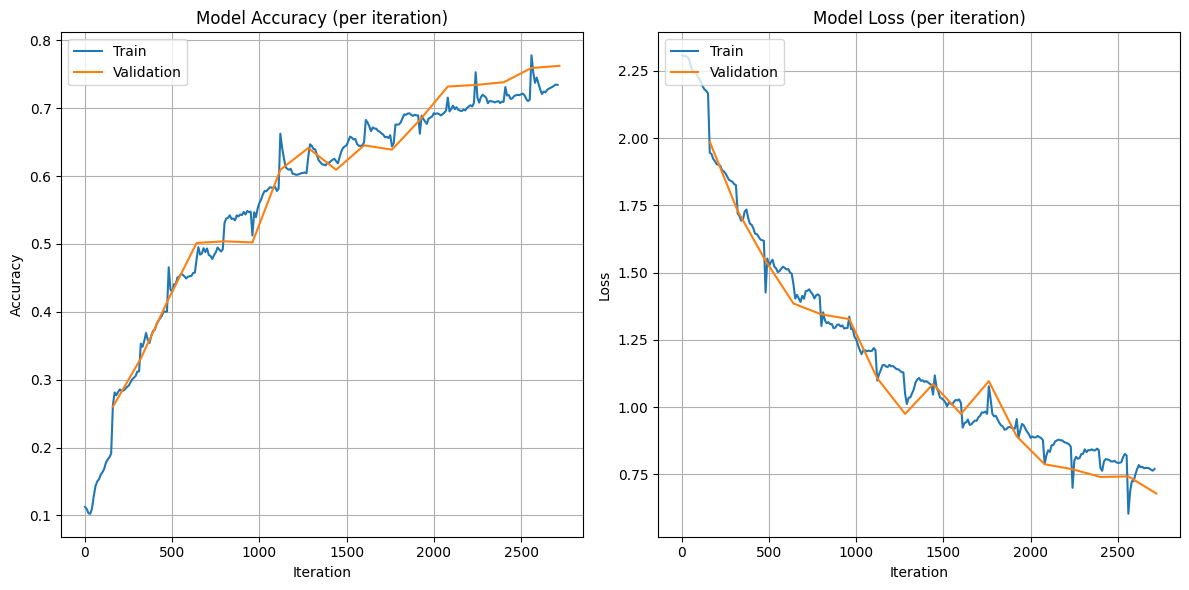

160/160 ━━━━━━━━━━━━━━━━━━━━ 82s 510ms/step - accuracy: 0.7345 - loss: 0.7472 - val_accuracy: 0.7625 - val_loss: 0.6784
Epoch 18/50
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 413ms/step - accuracy: 0.7358 - loss: 0.7449

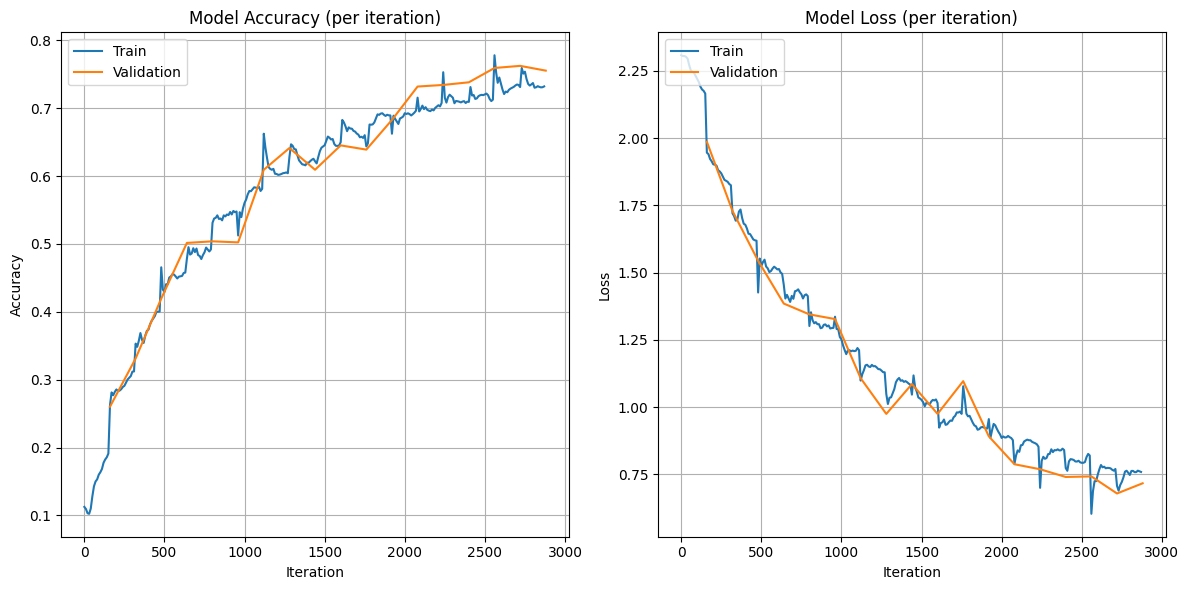

160/160 ━━━━━━━━━━━━━━━━━━━━ 81s 505ms/step - accuracy: 0.7358 - loss: 0.7450 - val_accuracy: 0.7555 - val_loss: 0.7163
Epoch 19/50
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 426ms/step - accuracy: 0.7530 - loss: 0.7221

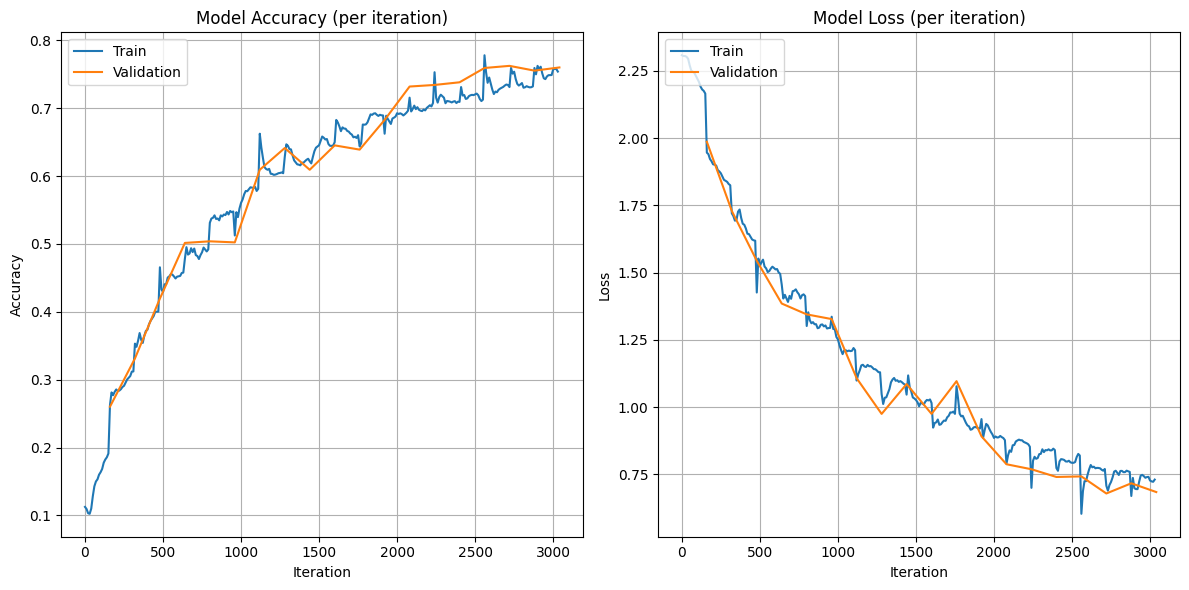

160/160 ━━━━━━━━━━━━━━━━━━━━ 83s 521ms/step - accuracy: 0.7531 - loss: 0.7222 - val_accuracy: 0.7602 - val_loss: 0.6837
Epoch 20/50
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 419ms/step - accuracy: 0.7712 - loss: 0.6856

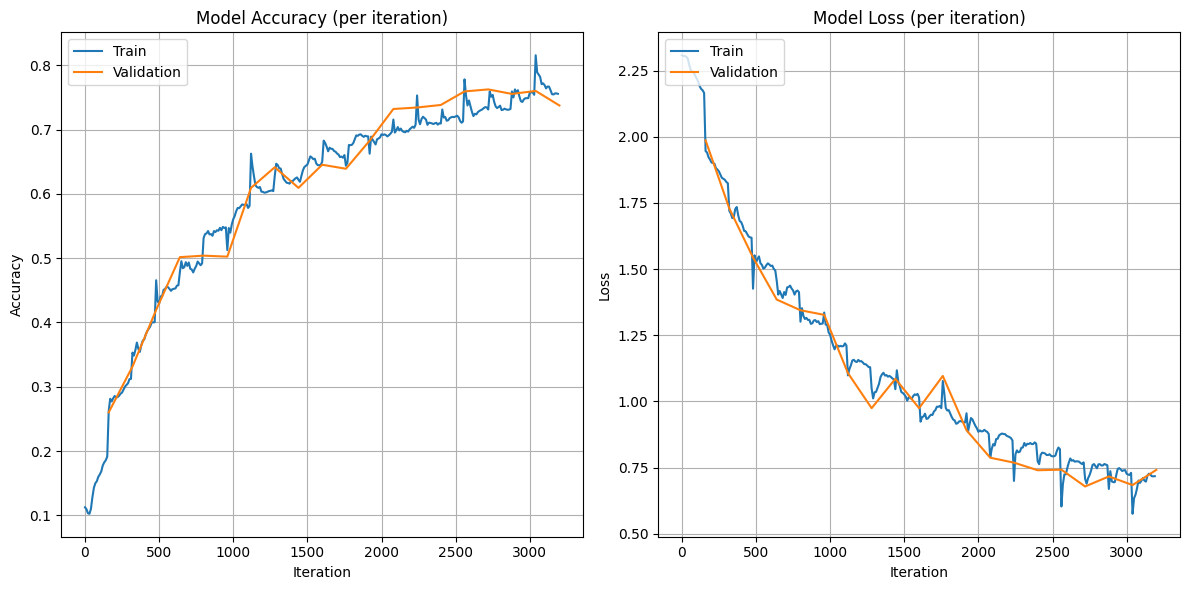

160/160 ━━━━━━━━━━━━━━━━━━━━ 140s 512ms/step - accuracy: 0.7711 - loss: 0.6858 - val_accuracy: 0.7375 - val_loss: 0.7410
Epoch 21/50
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 420ms/step - accuracy: 0.7734 - loss: 0.6834

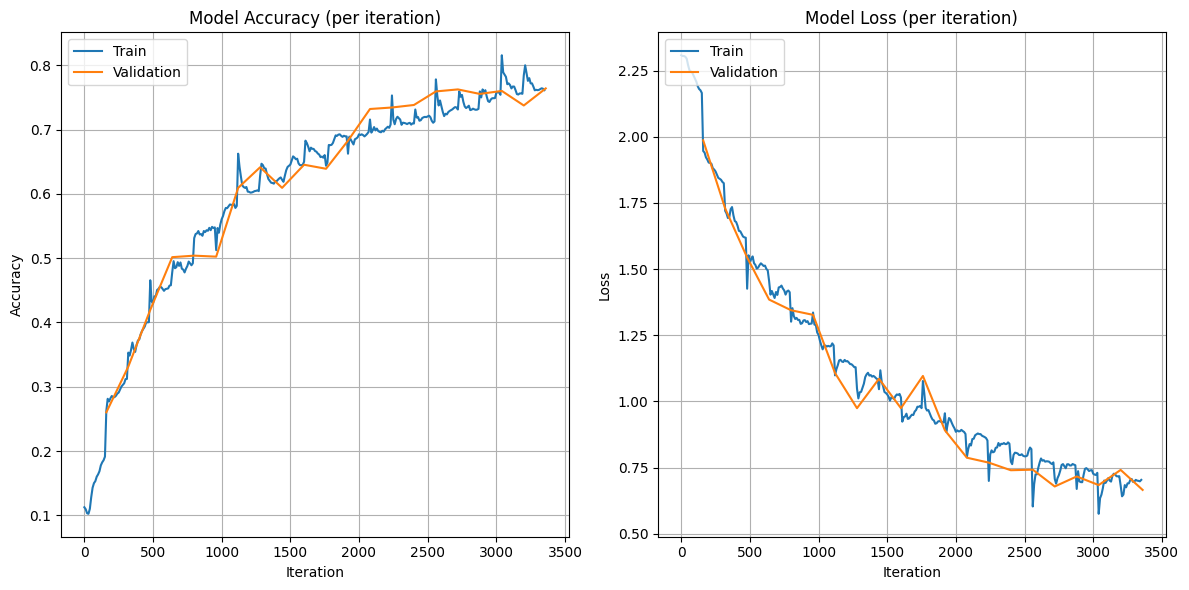

160/160 ━━━━━━━━━━━━━━━━━━━━ 142s 512ms/step - accuracy: 0.7733 - loss: 0.6835 - val_accuracy: 0.7641 - val_loss: 0.6654
Epoch 22/50
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 420ms/step - accuracy: 0.7678 - loss: 0.6584

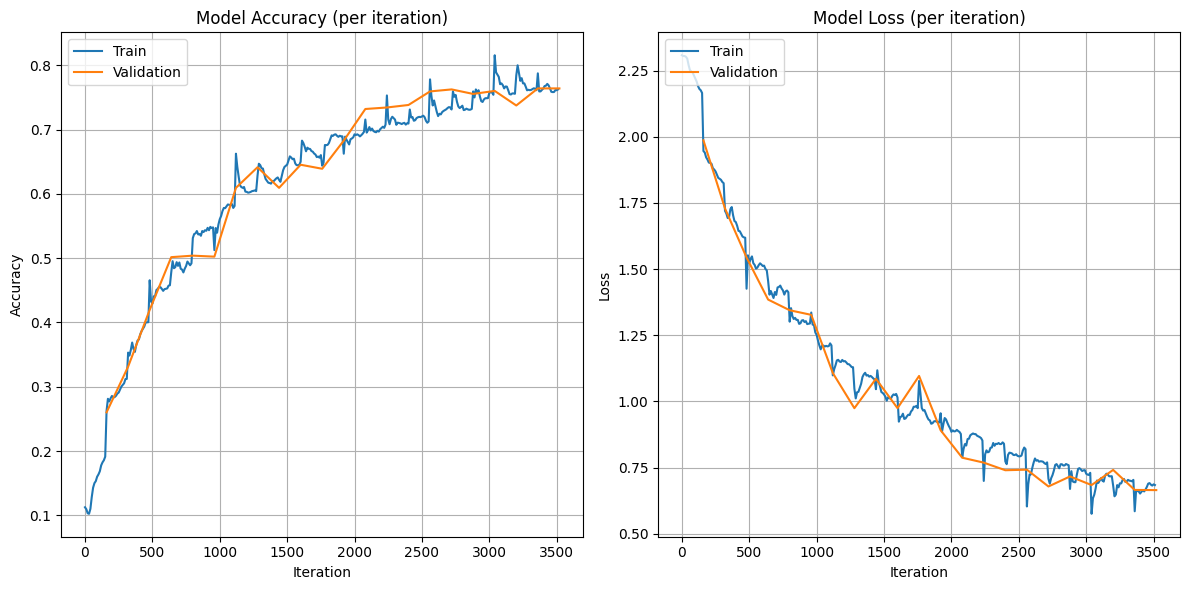

160/160 ━━━━━━━━━━━━━━━━━━━━ 142s 514ms/step - accuracy: 0.7677 - loss: 0.6585 - val_accuracy: 0.7641 - val_loss: 0.6647
Epoch 23/50
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 420ms/step - accuracy: 0.7731 - loss: 0.6726

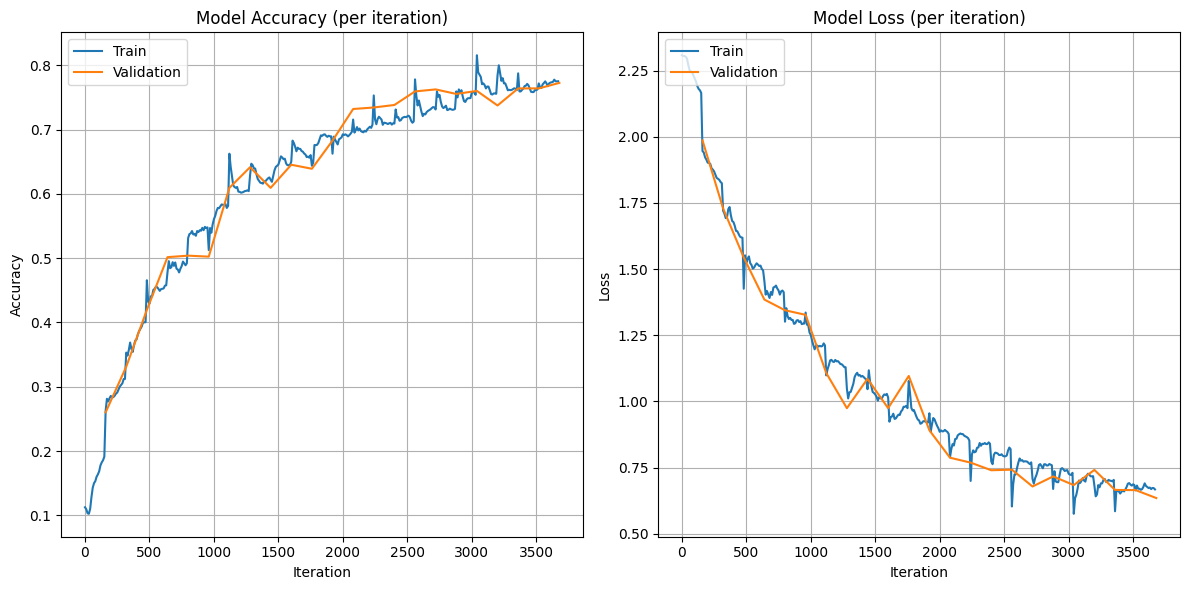

160/160 ━━━━━━━━━━━━━━━━━━━━ 142s 512ms/step - accuracy: 0.7731 - loss: 0.6726 - val_accuracy: 0.7727 - val_loss: 0.6347
Epoch 24/50
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 416ms/step - accuracy: 0.7889 - loss: 0.5986

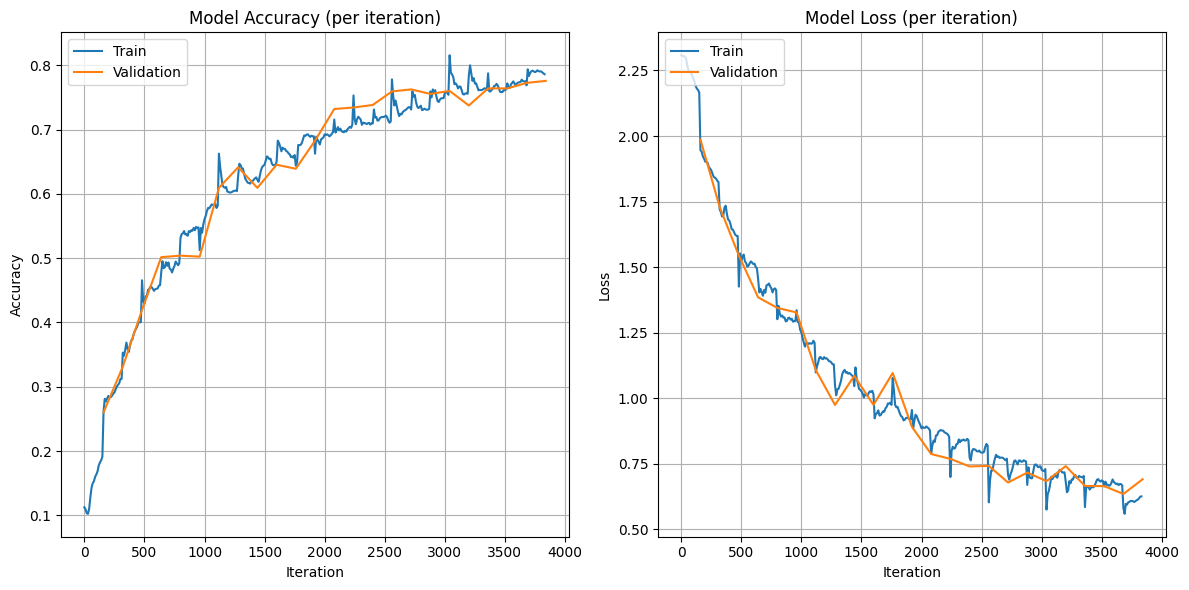

160/160 ━━━━━━━━━━━━━━━━━━━━ 82s 513ms/step - accuracy: 0.7889 - loss: 0.5987 - val_accuracy: 0.7758 - val_loss: 0.6911
Epoch 25/50
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 414ms/step - accuracy: 0.7894 - loss: 0.5972

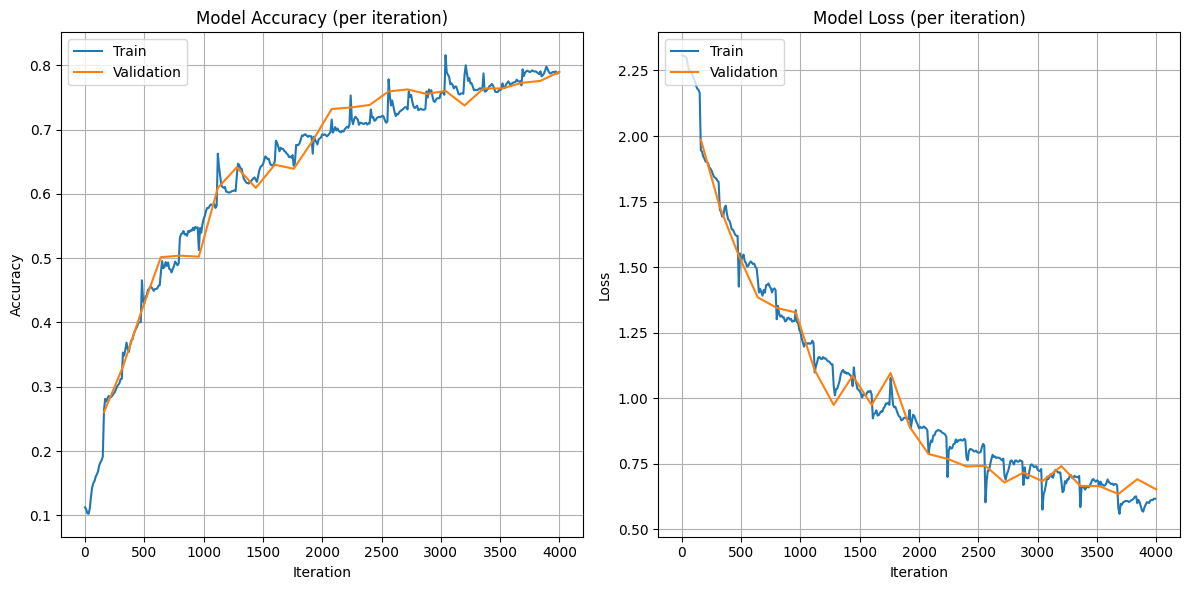

160/160 ━━━━━━━━━━━━━━━━━━━━ 81s 507ms/step - accuracy: 0.7894 - loss: 0.5973 - val_accuracy: 0.7898 - val_loss: 0.6520
Epoch 26/50
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 422ms/step - accuracy: 0.8030 - loss: 0.5783

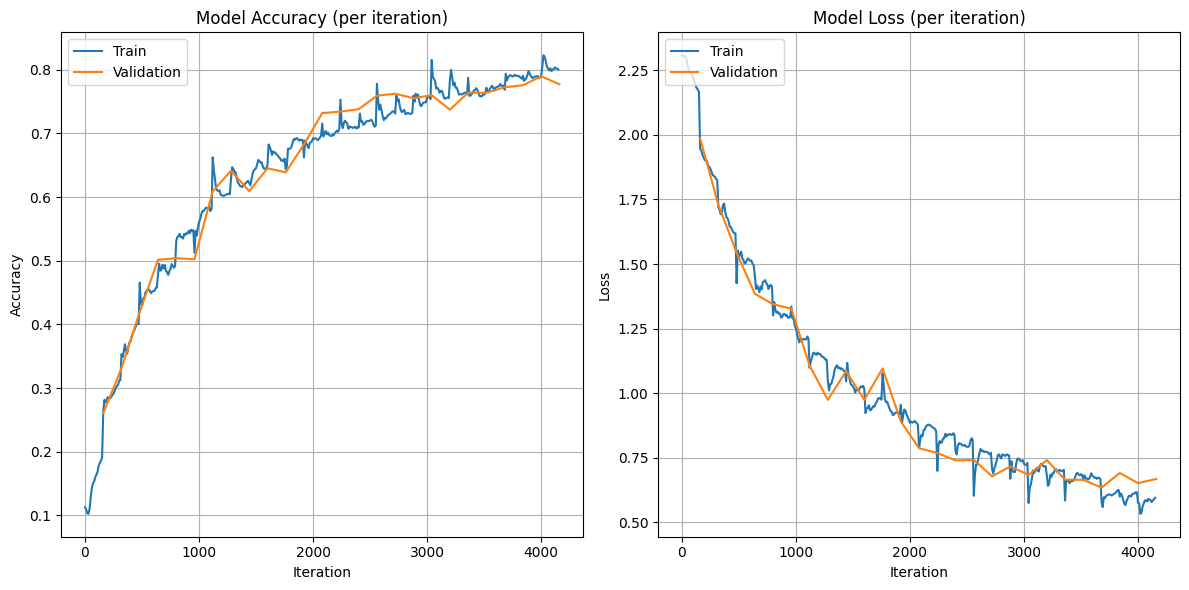

160/160 ━━━━━━━━━━━━━━━━━━━━ 82s 515ms/step - accuracy: 0.8029 - loss: 0.5784 - val_accuracy: 0.7773 - val_loss: 0.6682
Epoch 27/50
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 422ms/step - accuracy: 0.7921 - loss: 0.6001

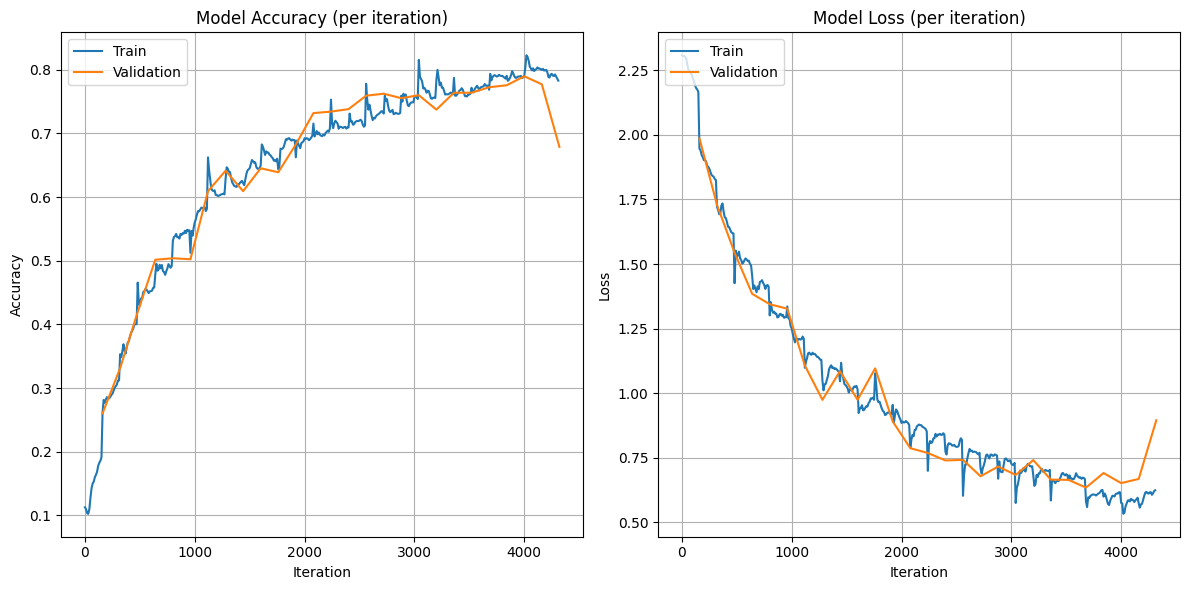

160/160 ━━━━━━━━━━━━━━━━━━━━ 142s 514ms/step - accuracy: 0.7920 - loss: 0.6003 - val_accuracy: 0.6789 - val_loss: 0.8953
Epoch 28/50
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 419ms/step - accuracy: 0.7787 - loss: 0.6208

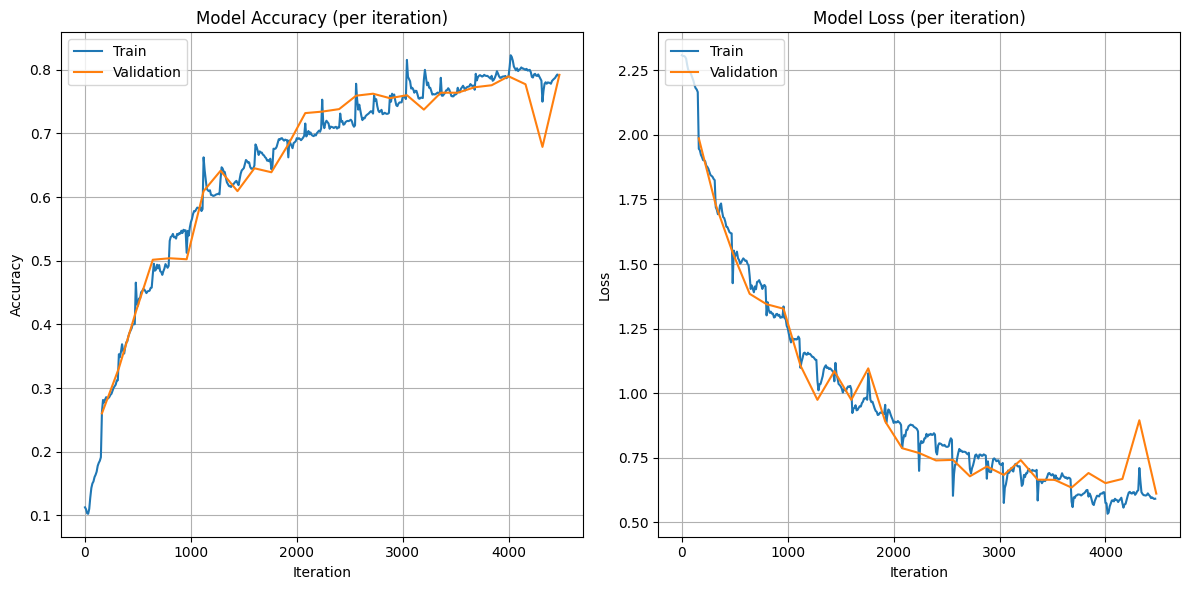

160/160 ━━━━━━━━━━━━━━━━━━━━ 82s 514ms/step - accuracy: 0.7788 - loss: 0.6207 - val_accuracy: 0.7922 - val_loss: 0.6115
Epoch 29/50
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 419ms/step - accuracy: 0.7962 - loss: 0.5769

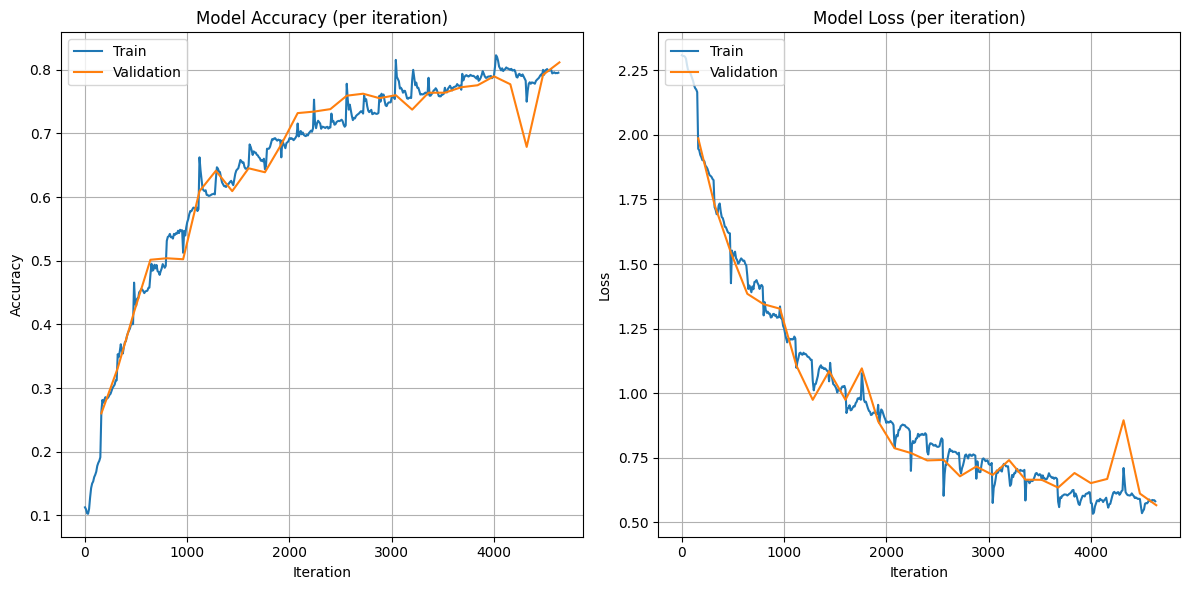

160/160 ━━━━━━━━━━━━━━━━━━━━ 82s 513ms/step - accuracy: 0.7962 - loss: 0.5769 - val_accuracy: 0.8117 - val_loss: 0.5665
Epoch 30/50
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 423ms/step - accuracy: 0.7979 - loss: 0.5672

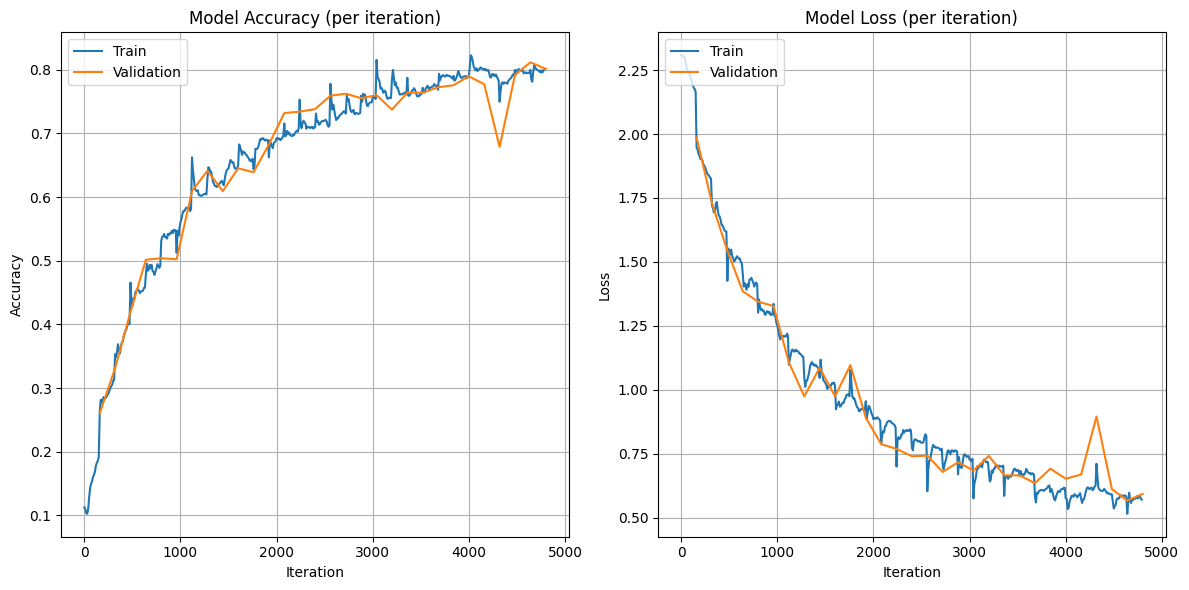

160/160 ━━━━━━━━━━━━━━━━━━━━ 83s 517ms/step - accuracy: 0.7979 - loss: 0.5672 - val_accuracy: 0.8016 - val_loss: 0.5922
Epoch 31/50
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 426ms/step - accuracy: 0.8069 - loss: 0.5714

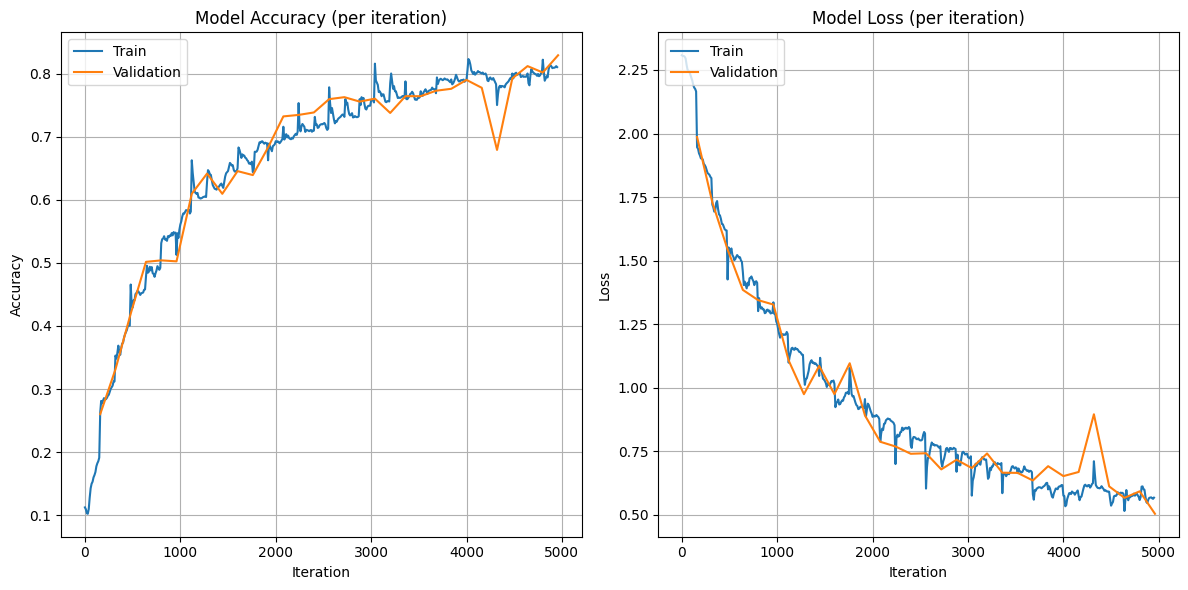

160/160 ━━━━━━━━━━━━━━━━━━━━ 83s 518ms/step - accuracy: 0.8069 - loss: 0.5714 - val_accuracy: 0.8289 - val_loss: 0.5037
Epoch 32/50
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 426ms/step - accuracy: 0.8109 - loss: 0.5325

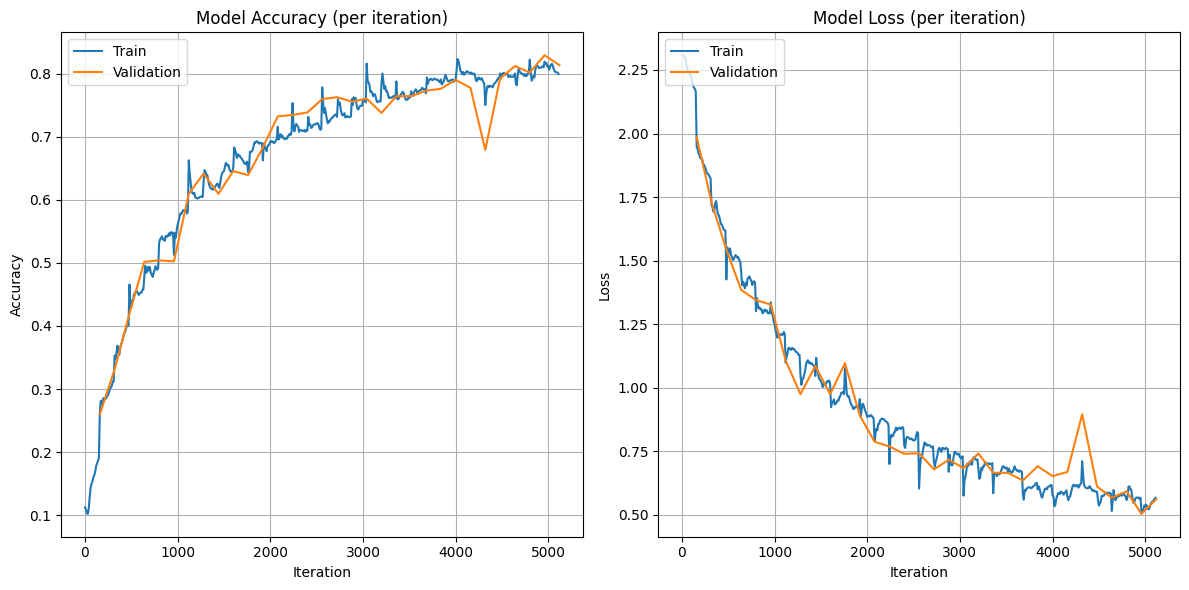

160/160 ━━━━━━━━━━━━━━━━━━━━ 142s 518ms/step - accuracy: 0.8108 - loss: 0.5327 - val_accuracy: 0.8133 - val_loss: 0.5611
Epoch 33/50
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 422ms/step - accuracy: 0.8270 - loss: 0.5156

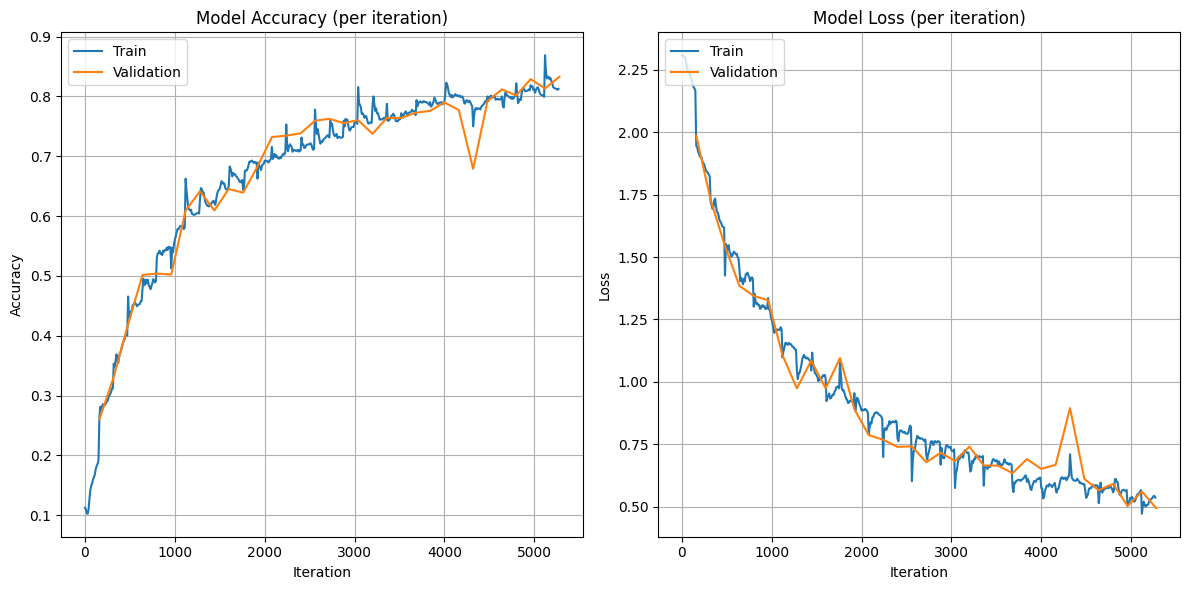

160/160 ━━━━━━━━━━━━━━━━━━━━ 141s 515ms/step - accuracy: 0.8269 - loss: 0.5158 - val_accuracy: 0.8328 - val_loss: 0.4947
Epoch 34/50
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 429ms/step - accuracy: 0.8056 - loss: 0.5690

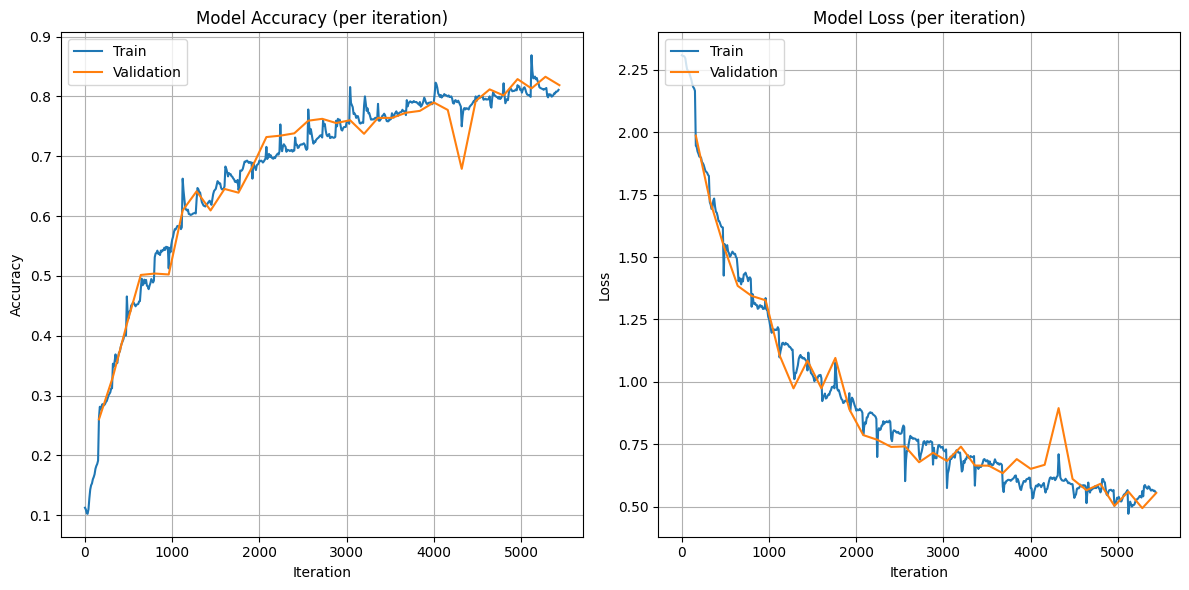

160/160 ━━━━━━━━━━━━━━━━━━━━ 143s 523ms/step - accuracy: 0.8056 - loss: 0.5689 - val_accuracy: 0.8188 - val_loss: 0.5558
Epoch 35/50
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 423ms/step - accuracy: 0.8258 - loss: 0.4941

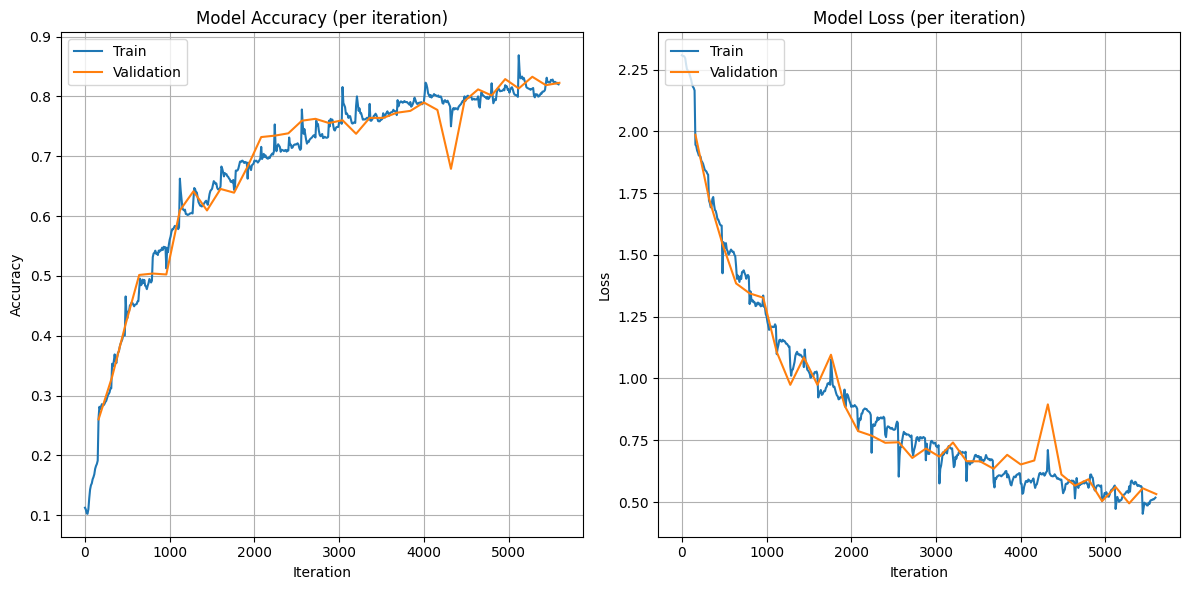

160/160 ━━━━━━━━━━━━━━━━━━━━ 141s 520ms/step - accuracy: 0.8258 - loss: 0.4943 - val_accuracy: 0.8227 - val_loss: 0.5321
Epoch 36/50
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 423ms/step - accuracy: 0.8259 - loss: 0.5136

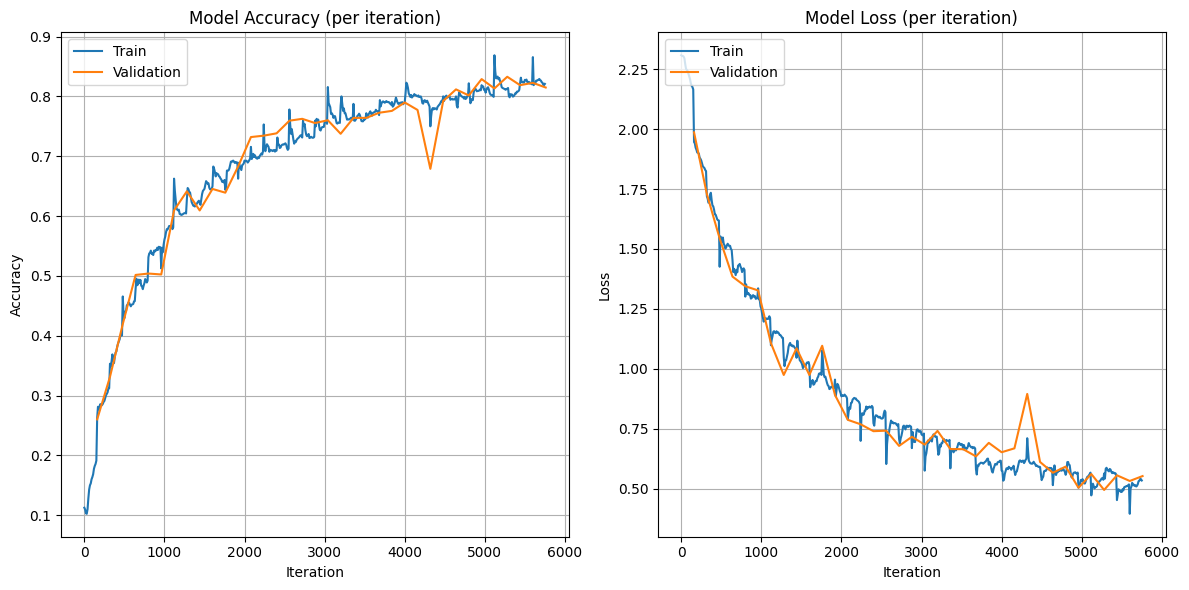

160/160 ━━━━━━━━━━━━━━━━━━━━ 142s 522ms/step - accuracy: 0.8259 - loss: 0.5137 - val_accuracy: 0.8148 - val_loss: 0.5526
Epoch 37/50
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 426ms/step - accuracy: 0.8306 - loss: 0.4925

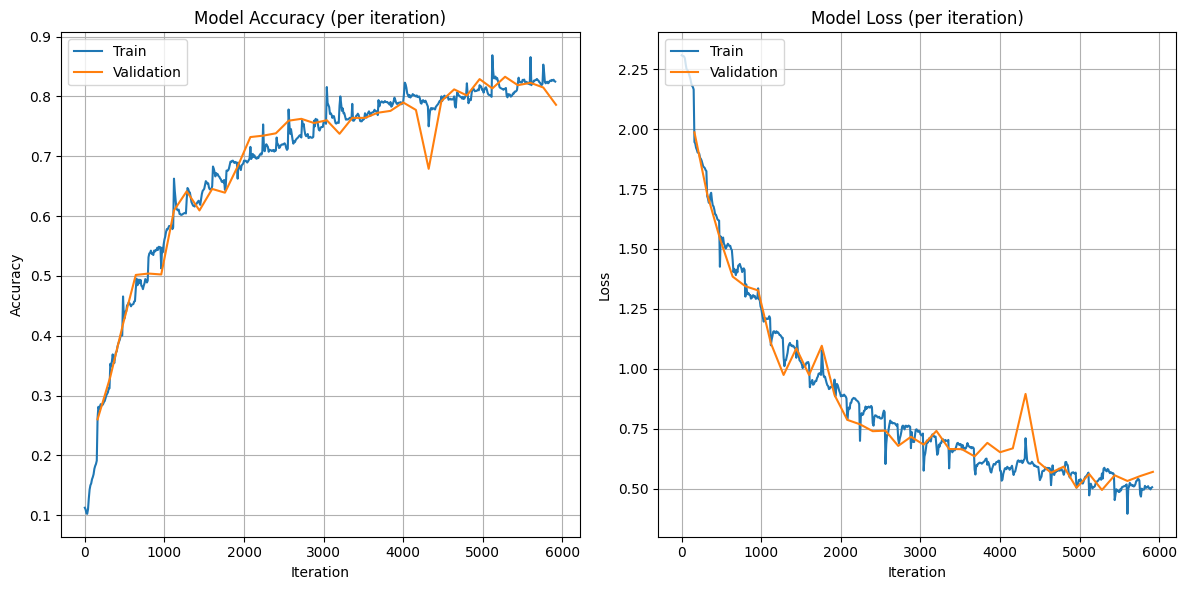

160/160 ━━━━━━━━━━━━━━━━━━━━ 142s 524ms/step - accuracy: 0.8305 - loss: 0.4926 - val_accuracy: 0.7859 - val_loss: 0.5702
Epoch 38/50
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 426ms/step - accuracy: 0.8152 - loss: 0.5050
 Tidak ada penurunan nilai loss validasi setelah 5 epochs. Proses train dihentikan...



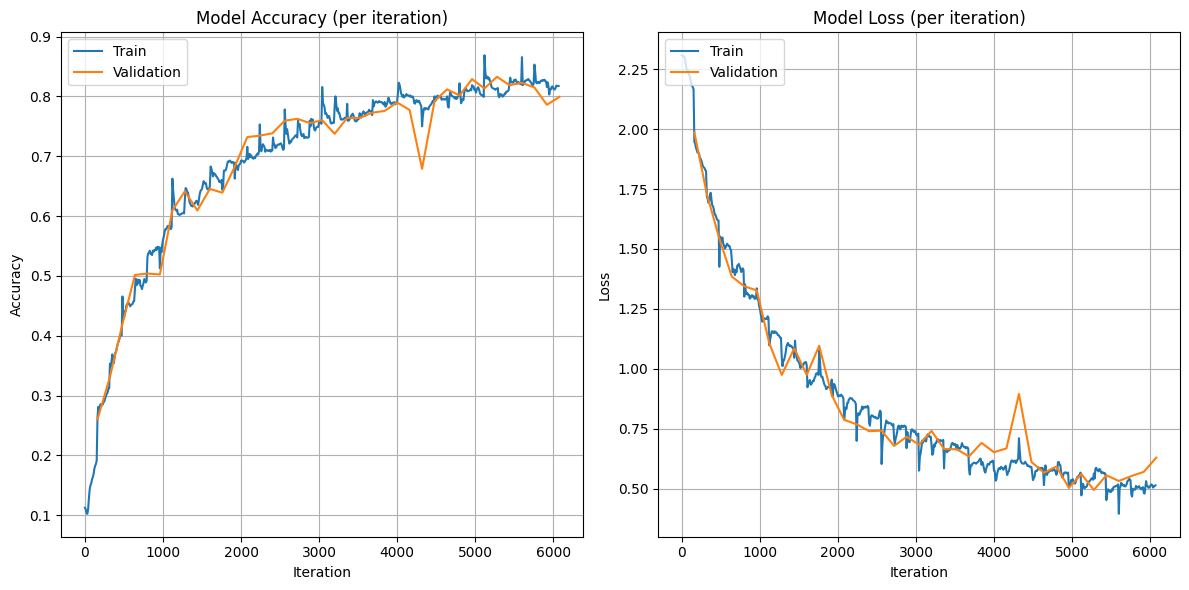

160/160 ━━━━━━━━━━━━━━━━━━━━ 142s 525ms/step - accuracy: 0.8152 - loss: 0.5051 - val_accuracy: 0.7992 - val_loss: 0.6296


In [16]:
# Compile and train the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(train_generator, validation_data=validation_generator, epochs=50, callbacks = [StopTrainingCallback(patience=5),plot_callback])

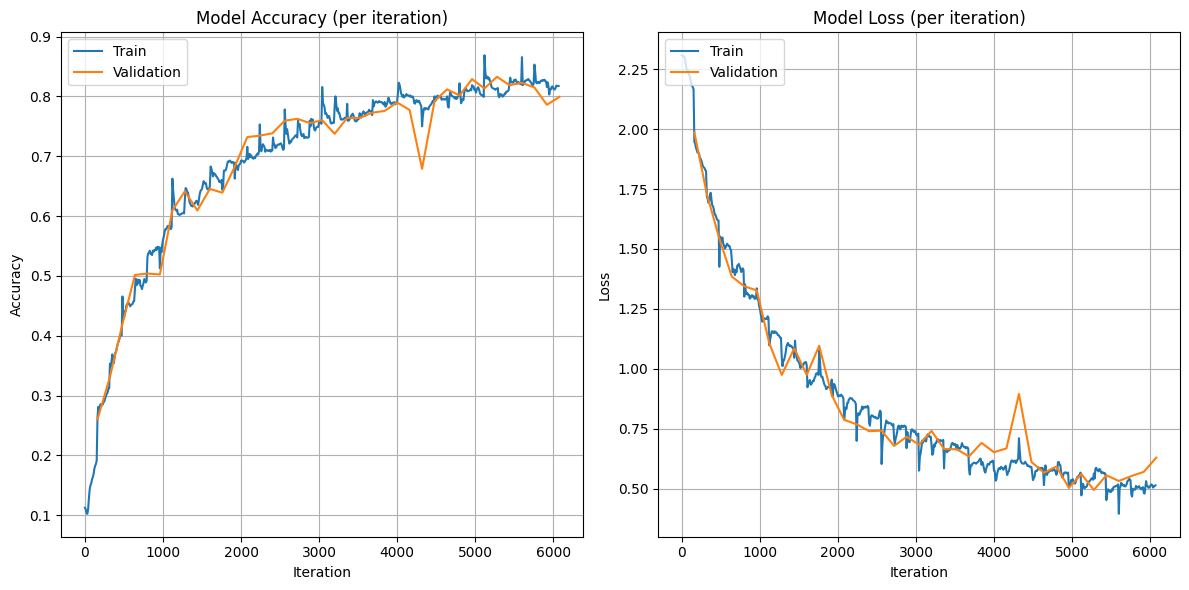

In [17]:
plot_callback.plot_metrics()

Found 1600 images belonging to 10 classes.
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 55ms/step - accuracy: 0.7663 - loss: 0.7189
Test Loss: 0.7549600005149841
Test Accuracy: 0.7699999809265137
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step


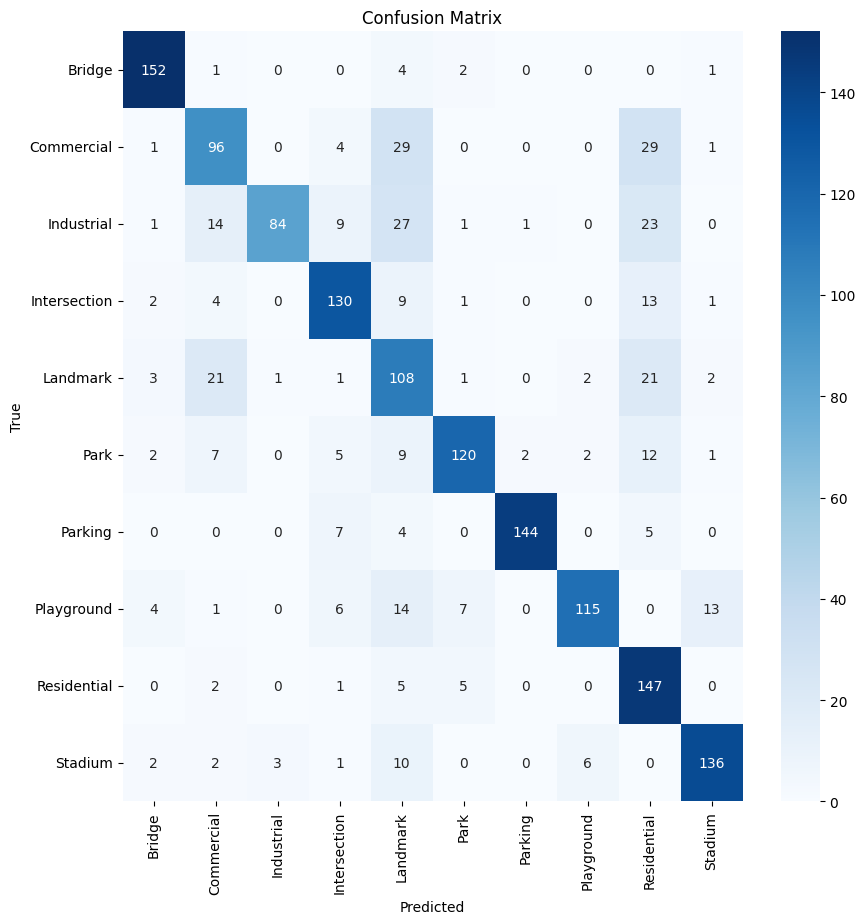

In [18]:
# prompt: buatkan kode untuk menguji model pada data tes yang terdapat pada "content/data/test"

import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Create an ImageDataGenerator for testing data without augmentation
test_datagen = ImageDataGenerator(rescale=1./255)

# Create a generator for the test data
test_generator = test_datagen.flow_from_directory(
    'data/test',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False  # Important: Set shuffle to False for consistent evaluation
)

# Evaluate the model on the test data
results = model.evaluate(test_generator)

# Print the results
print("Test Loss:", results[0])
print("Test Accuracy:", results[1])

# Get predictions on the test data
predictions = model.predict(test_generator)

# Get predicted classes
predicted_classes = np.argmax(predictions, axis=1)

# Get true classes
true_classes = test_generator.classes

# Confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(true_classes, predicted_classes)
plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=test_generator.class_indices.keys(), yticklabels=test_generator.class_indices.keys())
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
!pip install tensorflowjs

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.1/89.1 kB 8.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.9/15.9 MB 61.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.6/10.6 MB 65.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 319.7/319.7 kB 29.0 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 4.25.6
    Uninstalling protobuf-4.25.6:
      Successfully uninstalled protobuf-4.25.6
  Attempting uninstall: packaging
    Found existing installation: packaging 24.2
    Uninstalling packaging-24.2:
      Successfully uninstalled packaging-24.2


In [ ]:
import tensorflowjs as tfjs
import tensorflow as tf

# Save the model in TensorFlow.js format
tfjs.converters.save_keras_model(model, 'tfjs_model')

# Convert and save the model in TensorFlow Lite format
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()
with open('model.tflite', 'wb') as f:
  f.write(tflite_model)


# Save the model for TensorFlow Serving
# Create a directory for the saved model
import os
model_version = 1
export_path = os.path.join('serving_model', str(model_version))
print('export_path = {}\n'.format(export_path))

if os.path.isdir(export_path):
    print('\nAlready saved a model, cleaning up\n')
    !rm -r {export_path}

tf.saved_model.save(model, export_path)
print('\nSaved model:')
!ls -l {export_path}


failed to lookup keras version from the file,
    this is likely a weight only file
Saved artifact at '/tmp/tmpge7qoakf'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, None, None, 3), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 10), dtype=tf.float32, name=None)
Captures:
  139191219732304: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139191219731344: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139191219727120: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139191188192336: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139191188193104: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139191188488848: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139191188490000: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139191188489424: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139191188489040: TensorSpec(shape=(), dtype=tf.resource, name=None)

In [ ]:
# prompt: gunakan salah satu model yang disimpan untuk menguji suatu gambar dari luar

import tensorflow as tf
import numpy as np
from PIL import Image

# Load the saved model
model = tf.keras.models.load_model('serving_model/1') # Replace with the actual path

# Preprocess the image
def preprocess_image(image_path):
    img = Image.open(image_path).resize((224, 224))
    img_array = np.array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)
    return img_array

# Path to the image you want to test
image_path = '/content/image_to_test.jpg' # Replace with the actual path

# Preprocess the image
preprocessed_image = preprocess_image(image_path)


# Make predictions
predictions = model.predict(preprocessed_image)

# Get the predicted class
predicted_class = np.argmax(predictions)

# Print the prediction
print(f"Predicted class: {predicted_class}")
# You might need to map the predicted_class index to the actual class label.
# This depends on how your labels were encoded when training the model.
# For example:
# class_labels = ['class_1', 'class_2', 'class_3']
# print(f"Predicted class: {class_labels[predicted_class]}")


ValueError: File format not supported: filepath=serving_model/1. Keras 3 only supports V3 `.keras` files and legacy H5 format files (`.h5` extension). Note that the legacy SavedModel format is not supported by `load_model()` in Keras 3. In order to reload a TensorFlow SavedModel as an inference-only layer in Keras 3, use `keras.layers.TFSMLayer(serving_model/1, call_endpoint='serving_default')` (note that your `call_endpoint` might have a different name).

In [ ]:
import tensorflow as tf
import numpy as np
from PIL import Image

# Load the saved model using tf.saved_model.load
model = tf.saved_model.load('serving_model/1')

# Preprocess the image
def preprocess_image(image_path):
    img = Image.open(image_path).resize((224, 224))
    img_array = np.array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)
    return img_array

# Path to the image you want to test
image_path = '/content/image_to_test.jpg' # Replace with the actual path

# Preprocess the image
preprocessed_image = preprocess_image(image_path)


# Make predictions
predictions = model.predict(preprocessed_image)

# Get the predicted class
predicted_class = np.argmax(predictions)

# Print the prediction
print(f"Predicted class: {predicted_class}")
# You might need to map the predicted_class index to the actual class label.
# This depends on how your labels were encoded when training the model.
# For example:
# class_labels = ['class_1', 'class_2', 'class_3']
# print(f"Predicted class: {class_labels[predicted_class]}")
